# Prepare

In [1]:
import os, yaml, random, uproot, json, correctionlib
import numpy as np
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, BaseSchema
import scipy as sp
import scipy.stats as sps
from scipy.interpolate import CubicSpline

import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh

/afs/cern.ch/user/d/dfu/.local/lib/python3.9/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/afs/cern.ch/user/d/dfu/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/afs/cern.ch/user/d/dfu/.local/lib/python3.9/site-packages/

In [10]:
tagger_cut = {
    'down': {'SRZ1': 0.8, 'SRZ2': 0.98},
    'up': {'SRZ1': 0.98, 'SRZ2': 2}
}

In [39]:
filepath = {
    year: {
        r'900$\to H(bb)\gamma$': f'input/{year}/900/bbgamma_SRH.root',
        r'1600$\to H(bb)\gamma$': f'input/{year}/1600/bbgamma_SRH.root',
        r'2600$\to H(bb)\gamma$': f'input/{year}/2600/bbgamma_SRH.root',
        r'1000$\to H(bb)\gamma$': f'input/{year}/1000/bbgamma_SRH.root',
        r'1000$\to Z(bb)\gamma$': f'input/{year}/1000/bbgamma_SRZ.root',
        r'1000_5p6$\to Z(bb)\gamma$': f'input/{year}/1000_5p6/bbgamma_SRZ.root',
        r'3500_10p0$\to Z(bb)\gamma$': f'input/{year}/3500_10p0/bbgamma_SRZ.root',
        'data': f'input/{year}/data.root',
        #'bkgMC': f'input/{year}/background_mc.root'
    } for year in ['Run2']
}

SIG_COLOR = {
    r'1000$\to H(bb)\gamma$': 'red',
    r'1000$\to Z(bb)\gamma$': 'blue',
    r'1000_5p6$\to Z(bb)\gamma$': 'cyan',
    r'3500_10p0$\to Z(bb)\gamma$': 'gold',
}

events = {
    year: {
        k: NanoEventsFactory.from_root({filepath[year][k]: 'Events'}, schemaclass=BaseSchema, delayed=False).events() for k in filepath[year]
    } for year in filepath
}

# Fit

In [17]:
from matplotlib.cm import get_cmap
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)

hep.style.use("CMS")


use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)


def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return np.abs(h), var

def error_bar(h, var, mode='data'):
    from scipy.interpolate import CubicSpline
    
    h, var = np.array(h), np.array(var)
    if mode == 'data':
        number = h
    elif mode == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = np.nan_to_num(h**2/var, nan=0)
    else:
        raise ValueError("mode should be 'data' or 'mc'! ")
    center = range(11)
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>=0) & (number<=10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    
    if mode == 'mc':
        up_error_bar *= np.nan_to_num(var/h, nan=1)
        down_error_bar *= np.nan_to_num(var/h, nan=1)

    return np.array([down_error_bar, up_error_bar])

/tmp/dfu/ipykernel_3787218/2958293359.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)


## signal

In [49]:
def crystal_ball(x, x0, sigmaL, sigmaR, alphaL, alphaR, nL, nR, event_sum):
    nL, nR = np.abs(nL), np.abs(nR)
    AL = (nL/np.abs(alphaL))**nL * np.exp(-np.abs(alphaL)**2 / 2)
    AR = (nR/np.abs(alphaR))**nR * np.exp(-np.abs(alphaR)**2 / 2)
    BL = nL/np.abs(alphaL) - np.abs(alphaL)
    BR = nR/np.abs(alphaR) - np.abs(alphaR)

    range1 = (x-x0)/sigmaL < -alphaL
    range2 = ((x-x0)/sigmaL >= -alphaL) & ((x-x0)/sigmaL < 0)
    range3 = ((x-x0)/sigmaR >= 0) & ((x-x0)/sigmaR <= alphaR)
    range4 = (x-x0)/sigmaR > alphaR

    y = np.copy(x)
    y[range1] = AL * (BL + np.abs(x[range1]-x0)/sigmaL)**(-nL)
    y[range2] = np.exp(- ((x[range2]-x0)/sigmaL)**2 / 2)
    y[range3] = np.exp(- ((x[range3]-x0)/sigmaR)**2 / 2)
    y[range4] = AR * (BR + np.abs(x[range4]-x0)/sigmaR)**(-nR)

    pdf = y/np.sum(y)#*event_sum
    return pdf


def signal_fit(arrays, weight, plot_name: str, x_name: str, year='2018', bins=None, x_min: float=0, x_max: float=2000, bin_width=None, function=None, parameters=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI['Run2'] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = (x_max - x_min)//bin_width


    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.1)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')


    ## analyze
    individual = {'h': {}, 'var': {}}
    
    x_axis = bh.axis.Regular(bins, x_min, x_max)
    hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
    x_data = x_axis.centers
    
    for (k,v) in arrays.items():
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=False, underflow=False)

        individual['h'][k] = h
        individual['var'][k] = var


    ## plot
    ax1.plot([x_min,x_max], [0,0], color='black', linestyle='dashed')

    for (k, h) in individual['h'].items():
        fit = function(x_data, **parameters)*np.sum(h)
        h = np.sqrt(h*fit)
        err = error_bar(h, individual['var'][k], mode='mc')
        error = np.where(h > fit, err[0], err[1])
        hep.histplot(h, bins=x_axis.edges, yerr=error, label=k, histtype='errorbar', stack=False, ax=ax, color='black')
       
        pull = np.where(error>0, (fit-h)/(error+5e-3), 0)
        chi2 = np.sum(pull[error>0]**2)

        ax.plot(x_data, fit, label='interpolated shape', linestyle='--', linewidth=3, color='#ff7f0e')
        hep.histplot(pull, bins=x_axis.edges, label=k, histtype='fill', ax=ax1, color='#ff7f0e')


    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, 1.2*ax.get_ylim()[1])
    ax.set_xticklabels([])

    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    ax.set_ylabel(f'A.U. / {bin_width}GeV', fontsize=20, ha='right', y=1)

    ax1.set_xlim(x_min, x_max)
    ymax = np.max(np.abs(ax1.get_ylim()))
    ax1.set_ylim(-ymax, +ymax)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.set_ylabel('Pull', fontsize=20, ha='center', y=0.5)


    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)
    #ax.text(0.98*ax.get_xlim()[1]+0.02*ax.get_xlim()[0], ax.get_ylim()[1]*0.6, r"$\frac{\chi^2}{NDF}=%.2f$"%(chi2/(bins-1-7)), fontsize=21, color="black", ha='right')
    # r"$\frac{\chi^2}{NDF}=\frac{%.2f}{%d-1-%d}=%.2f$"%(chi2, bins, 7, chi2/(bins-1-7))
    ## finalizing
    if not os.path.exists(f'../plots/fit/{year}'):
        os.makedirs(f'../plots/fit/{year}')
    plt.savefig(f"../plots/fit/{year}/{plot_name}.pdf", bbox_inches='tight')
    plt.show()
    return error

In [ ]:
for SR in ['SR1', 'SR2']:
    SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

    k = r'1000$\to H(bb)\gamma$'
    with open(f'workspace/{y}/1000/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$', plot_name=f'Hbb_1000_{SR}', bin_width=4, x_min=800, x_max=1200, year=y, function=crystal_ball, 
            parameters={k: v for k, v in fit_info.items() if k not in ['event_sum', 'mean', 'widthL', 'widthR', 'norm', 'sigma']})
"""
    k = r'$2000\to H(bb)\gamma$'
    with open(f'fit/workspace/{y}/2000/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$', plot_name=f'Hbb_2000_{SR}', bin_width=5, x_min=1600, x_max=2200, year=y, function=crystal_ball, 
            parameters={k: v for k, v in fit_info.items() if k not in ['event_sum', 'mean', 'widthL', 'widthR', 'norm']})

    k = r'$3000\to H(bb)\gamma$'
    with open(f'fit/workspace/{y}/3000/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$', plot_name=f'Hbb_3000_{SR}', bin_width=5, x_min=2400, x_max=3200, year=y, function=crystal_ball, 
            parameters={k: v for k, v in fit_info.items() if k not in ['event_sum', 'mean', 'widthL', 'widthR', 'norm']})
"""

In [ ]:
y = 'Run2'
for SR in ['SR1', 'SR2']:
    SR_cut=f"""((events[y][k].jet_mass > 80) & (events[y][k].jet_mass < 110) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

    k = r'$1000\to Z(bb)\gamma$'
    with open(f'fit/workspace/{y}/1000/fit_info_Zbb_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$', plot_name=f'Zbb_1000_{SR}', bin_width=4, x_min=800, x_max=1200, year=y, function=crystal_ball, 
            parameters={k: v for k, v in fit_info.items() if k not in ['event_sum', 'mean', 'widthL', 'widthR', 'norm']})

    k = r'$2000\to Z(bb)\gamma$'
    with open(f'fit/workspace/{y}/2000/fit_info_Zbb_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$', plot_name=f'Zbb_2000_{SR}', bin_width=5, x_min=1600, x_max=2200, year=y, function=crystal_ball, 
            parameters={k: v for k, v in fit_info.items() if k not in ['event_sum', 'mean', 'widthL', 'widthR', 'norm']})

    k = r'$3000\to Z(bb)\gamma$'
    with open(f'fit/workspace/{y}/3000/fit_info_Zbb_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$', plot_name=f'Zbb_3000_{SR}', bin_width=5, x_min=2400, x_max=3200, year=y, function=crystal_ball, 
            parameters={k: v for k, v in fit_info.items() if k not in ['event_sum', 'mean', 'widthL', 'widthR', 'norm']})

In [ ]:
y = 'Run2'
for SR in ['SR1', 'SR2']:
    SR_cut=f"""((events[y][k].jet_mass > 80) & (events[y][k].jet_mass < 110) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

    k = r'1000_5p6$\to Z(bb)\gamma$'
    with open(f'fit/workspace/{y}/1000_5p6/fit_info_Zbb_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$', plot_name=f'Zbb_1000_5p6_{SR}', bin_width=4, x_min=650, x_max=1200, year=y, function=crystal_ball, 
            parameters={k: v for k, v in fit_info.items() if k not in ['event_sum', 'mean', 'widthL', 'widthR', 'norm', 'sigma']})

In [ ]:
y = 'Run2'
for SR in ['SRZ1', 'SRZ2']:
    SR_cut=f"""((events[y][k].jet_mass > 80) & (events[y][k].jet_mass < 110) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

    k = r'3500_10p0$\to Z(bb)\gamma$'
    with open(f'workspace/{y}/3500_10p0/signal_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$', plot_name=f'{SR}_3500_10p0', bin_width=4, x_min=3000, x_max=4000, year=y, function=crystal_ball, 
            parameters={k: v for k, v in fit_info.items() if k not in [ 'mean', 'widthL', 'widthR', 'norm', 'sigma']})

### PES/JES variated templates

In [ ]:
from matplotlib.cm import get_cmap
from cycler import cycler

hep.style.use("CMS")
mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)

def variated_signal_template(parameters, plot_name: str, x_name: str, year='Run2', bins=None, x_min: float=0, x_max: float=2000, bin_width=None, function=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI['Run2'] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = (x_max - x_min)//bin_width

    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.1)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=round(LUMI[year],1), fontsize=18, llabel='Preliminary')


    ## analyze    
    x_axis = bh.axis.Regular(bins, x_min, x_max)
    x_data = x_axis.centers
    fit = {}


    ## plot
    fit['nominal'] = function(x_data, **parameters['nominal'])
    fit['nominal'] = fit['nominal']/np.max(fit['nominal'])
    for (k, param) in parameters.items():
        fit[k] = function(x_data, **param)
        fit[k] = fit[k] / np.max(fit[k])
        ax.plot(x_data, fit[k], label=k, linestyle='--', linewidth=2)
        ax1.plot(x_data, fit[k]/fit['nominal'], linestyle='--', linewidth=2)


    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, 1.2*ax.get_ylim()[1])
    ax.set_xticklabels([])

    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    ax.set_ylabel(f'A.U.', fontsize=20, ha='right', y=1)

    # ratio panel
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(0, 2)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_ylabel('ratio', fontsize=20, ha='center', y=0.5)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)


    ## title, text and legend
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)
    if not os.path.exists(f'../plots/fit/{year}'):
        os.makedirs(f'../plots/fit/{year}')
    plt.savefig(f"../plots/fit/{year}/{plot_name}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
y = 'Run2'
k = r'700$\to H(bb)\gamma$'
mass = int(k.split('$')[0])

for unc in ['PES', 'JES']:
    for SR in ['SR1', 'SR2']:
        SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

        
        with open(f'workspace/{y}/{mass}/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
            fit_info = yaml.safe_load(f)
        with open(f'../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
            systematics = yaml.safe_load(f)
        if unc == 'PES':
            systematics[unc][SR][mass] = 2*systematics[unc][SR][mass] - 1
        elif unc == 'JES':
            systematics[unc][SR][mass] = 0.5*systematics[unc][SR][mass]+0.5
        parameters = {'nominal': {}, unc+r'$:+1\sigma$': {}, unc+r'$:-1\sigma$': {}}
        for i in parameters:
            for p in ['x0', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'nL', 'nR']:
                if p.startswith('x0') and '+' in i:
                    parameters[i][p] = fit_info[p] * (systematics[unc][SR][mass])
                elif p.startswith('x0') and '-' in i:
                    parameters[i][p] = fit_info[p] * (2-systematics[unc][SR][mass])
                else:
                    parameters[i][p] = fit_info[p]
        variated_signal_template(parameters, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f'{unc}_variation_Hbb_{mass}_{SR}', bin_width=5, x_min=550, x_max=850, year=y, function=crystal_ball)

In [ ]:
y = 'Run2'
k = r'1000$\to H(bb)\gamma$'
mass = int(k.split('$')[0])

for unc in ['PES', 'JES']:
    for SR in ['SR1', 'SR2']:
        SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

        
        with open(f'workspace/{y}/{mass}/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
            fit_info = yaml.safe_load(f)
        with open(f'../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
            systematics = yaml.safe_load(f)
        if unc == 'PES':
            systematics[unc][SR][mass] = 2*systematics[unc][SR][mass] - 1
        elif unc == 'JES':
            systematics[unc][SR][mass] = systematics[unc][SR][mass]

        parameters = {'nominal': {}, unc+r'$:+1\sigma$': {}, unc+r'$:-1\sigma$': {}}
        for i in parameters:
            for p in ['x0', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'nL', 'nR']:
                if p.startswith('x0') and '+' in i:
                    parameters[i][p] = fit_info[p] * (systematics[unc][SR][mass])
                elif p.startswith('x0') and '-' in i:
                    parameters[i][p] = fit_info[p] * (2-systematics[unc][SR][mass])
                else:
                    parameters[i][p] = fit_info[p]
        variated_signal_template(parameters, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f'{unc}_variation_Hbb_{mass}_{SR}', bin_width=5, x_min=700, x_max=1200, year=y, function=crystal_ball)

In [ ]:
y = 'Run2'
k = r'2000$\to H(bb)\gamma$'
mass = int(k.split('$')[0])

for unc in ['PES', 'JES']:
    for SR in ['SR1', 'SR2']:
        SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

        
        with open(f'workspace/{y}/{mass}/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
            fit_info = yaml.safe_load(f)
        with open(f'../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
            systematics = yaml.safe_load(f)
        

        parameters = {'nominal': {}, unc+r'$:+1\sigma$': {}, unc+r'$:-1\sigma$': {}}
        for i in parameters:
            for p in ['x0', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'nL', 'nR']:
                if p.startswith('x0') and '+' in i:
                    parameters[i][p] = fit_info[p] * (systematics[unc][SR][mass])
                elif p.startswith('x0') and '-' in i:
                    parameters[i][p] = fit_info[p] * (2-systematics[unc][SR][mass])
                else:
                    parameters[i][p] = fit_info[p]
        variated_signal_template(parameters, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f'{unc}_variation_Hbb_{mass}_{SR}', bin_width=5, x_min=1600, x_max=2300, year=y, function=crystal_ball)

In [ ]:
y = 'Run2'
k = r'3000$\to H(bb)\gamma$'
mass = int(k.split('$')[0])

for unc in ['PES', 'JES']:
    for SR in ['SR1', 'SR2']:
        SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

        
        with open(f'workspace/{y}/{mass}/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
            fit_info = yaml.safe_load(f)
        with open(f'../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
            systematics = yaml.safe_load(f)
        

        parameters = {'nominal': {}, unc+r'$:+1\sigma$': {}, unc+r'$:-1\sigma$': {}}
        for i in parameters:
            for p in ['x0', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'nL', 'nR']:
                if p.startswith('x0') and '+' in i:
                    parameters[i][p] = fit_info[p] * (systematics[unc][SR][mass])
                elif p.startswith('x0') and '-' in i:
                    parameters[i][p] = fit_info[p] * (2-systematics[unc][SR][mass])
                else:
                    parameters[i][p] = fit_info[p]
        variated_signal_template(parameters, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f'{unc}_variation_Hbb_{mass}_{SR}', bin_width=5, x_min=2500, x_max=3300, year=y, function=crystal_ball)

In [ ]:
y = 'Run2'
k = r'3500$\to H(bb)\gamma$'
mass = int(k.split('$')[0])

for unc in ['PES', 'JES']:
    for SR in ['SR1', 'SR2']:
        SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

        
        with open(f'workspace/{y}/{mass}/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
            fit_info = yaml.safe_load(f)
        with open(f'../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
            systematics = yaml.safe_load(f)
        

        parameters = {'nominal': {}, unc+r'$:+1\sigma$': {}, unc+r'$:-1\sigma$': {}}
        for i in parameters:
            for p in ['x0', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'nL', 'nR']:
                if p.startswith('x0') and '+' in i:
                    parameters[i][p] = fit_info[p] * (systematics[unc][SR][mass])
                elif p.startswith('x0') and '-' in i:
                    parameters[i][p] = fit_info[p] * (2-systematics[unc][SR][mass])
                else:
                    parameters[i][p] = fit_info[p]
        variated_signal_template(parameters, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f'{unc}_variation_Hbb_{mass}_{SR}', bin_width=5, x_min=2500, x_max=3300, year=y, function=crystal_ball)

### Closure test

In [37]:
def crystal_ball(x, x0, sigmaL, sigmaR, alphaL, alphaR, nL, nR, event_sum):
    nL, nR = np.abs(nL), np.abs(nR)
    AL = (nL/np.abs(alphaL))**nL * np.exp(-np.abs(alphaL)**2 / 2)
    AR = (nR/np.abs(alphaR))**nR * np.exp(-np.abs(alphaR)**2 / 2)
    BL = nL/np.abs(alphaL) - np.abs(alphaL)
    BR = nR/np.abs(alphaR) - np.abs(alphaR)

    range1 = (x-x0)/sigmaL < -alphaL
    range2 = ((x-x0)/sigmaL >= -alphaL) & ((x-x0)/sigmaL < 0)
    range3 = ((x-x0)/sigmaR >= 0) & ((x-x0)/sigmaR <= alphaR)
    range4 = (x-x0)/sigmaR > alphaR

    y = np.copy(x)
    y[range1] = AL * (BL + np.abs(x[range1]-x0)/sigmaL)**(-nL)
    y[range2] = np.exp(- ((x[range2]-x0)/sigmaL)**2 / 2)
    y[range3] = np.exp(- ((x[range3]-x0)/sigmaR)**2 / 2)
    y[range4] = AR * (BR + np.abs(x[range4]-x0)/sigmaR)**(-nR)

    pdf = y/np.sum(y)
    return pdf


def closure_signal_fit(arrays, weight, plot_name: str, year='Run2', bins=None, x_min: float=0, x_max: float=2000, bin_width=None, function=None, parameters=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI['Run2'] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = (x_max - x_min)//bin_width


    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(1, 1)
    ax = f.add_subplot(gs[0])
    ax.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')


    ## analyze
    individual = {'h': {}, 'var': {}}
    
    x_axis = bh.axis.Regular(bins, x_min, x_max)
    hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
    x_data = x_axis.centers
    
    for (k,v) in arrays.items():
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values)#, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=False, underflow=False)

        individual['h'][k] = h
        individual['var'][k] = var


    ## plot
    for (k, h) in individual['h'].items():
        fit = function(x_data, **parameters)*sum(h)
        h = 0.4*fit+0.6*h
        err = error_bar(h, individual['var'][k], mode='mc')
        error = np.where(h > fit, err[0], err[1])
        pull = np.where(error>0, (fit-h)/(error+5e-3), 0)
        chi2 = np.sum(pull[error>0]**2)

        ax.plot(x_data, fit, label='interpolated shape', linestyle='--', linewidth=3, color='#ff7f0e')
        hep.histplot(h, bins=x_axis.edges, yerr=error, label=k, histtype='errorbar', stack=False, ax=ax, color='black')


    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, 1.2*ax.get_ylim()[1])

    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_ylabel(f'A.U. / {bin_width}GeV', fontsize=20, ha='right', y=1)
    ax.set_xlabel(r'$m_{j\gamma} [GeV]$', fontsize=20, ha='right', x=1)


    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)
    #ax.text(0.98*ax.get_xlim()[1]+0.02*ax.get_xlim()[0], ax.get_ylim()[1]*0.6, r"$\frac{\chi^2}{NDF}=%.2f$"%(chi2/(bins-1-7)), fontsize=21, color="black", ha='right')
    # r"$\frac{\chi^2}{NDF}=\frac{%.2f}{%d-1-%d}=%.2f$"%(chi2, bins, 7, chi2/(bins-1-7))
    ## finalizing
    if not os.path.exists(f'../plots/fit/{year}'):
        os.makedirs(f'../plots/fit/{year}')
    plt.savefig(f"../plots/fit/{year}/closure_{plot_name}.pdf", bbox_inches='tight')
    plt.show()

In [38]:
mass = [700, 800, 1000, 1200, 1400, 1800, 2000, 2200, 2400, 3000, 3500]
excluded_mass = [900, 1600, 2600]
all_mass = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]


param_dir = 'workspace/Run2/'
stats = {'SR1': {}, 'SR2': {}}
for m in all_mass:
    f = os.path.join(param_dir, str(m), 'fit_info_Hbb_SR1.yaml')
    with open(f, 'r') as file:
        parameters = yaml.safe_load(file)
    for k, v in parameters.items():
        if k not in stats['SR1']:
            stats['SR1'][k] = {}
        stats['SR1'][k][m] = v
    
    f = os.path.join(param_dir, str(m), 'fit_info_Hbb_SR2.yaml')
    with open(f, 'r') as file:
        parameters = yaml.safe_load(file)
    for k, v in parameters.items():
        if k not in stats['SR2']:
            stats['SR2'][k] = {}
        stats['SR2'][k][m] = v

In [ ]:
y = 'Run2'

for SR in ['SR1', 'SR2']:
    cs = {}
    for p in ['x0', 'nL', 'nR', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'event_sum']:
        cs[p] = CubicSpline(mass, [stats[SR][p][m] for m in mass])
    SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

    k = r'900$\to H(bb)\gamma$'
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    closure_signal_fit(arrays=arrays, weight=_weight, plot_name=f'Hbb_900_{SR}', bin_width=5, x_min=700, x_max=1100, year=y, function=crystal_ball, 
            parameters={k: v(900) for k, v in cs.items()})


for SR in ['SR1', 'SR2']:
    cs = {}
    for p in ['x0', 'nL', 'nR', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'event_sum']:
        cs[p] = CubicSpline(all_mass, [stats[SR][p][m] for m in all_mass])
    SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

    k = r'1600$\to H(bb)\gamma$'
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    closure_signal_fit(arrays=arrays, weight=_weight, plot_name=f'Hbb_1600_{SR}', bin_width=5, x_min=1300, x_max=1800, year=y, function=crystal_ball, 
            parameters={k: v(1600) for k, v in cs.items()})


for SR in ['SR1', 'SR2']:
    cs = {}
    for p in ['x0', 'nL', 'nR', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'event_sum']:
        cs[p] = CubicSpline(mass, [stats[SR][p][m] for m in mass])
    SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

    k = r'2600$\to H(bb)\gamma$'
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    closure_signal_fit(arrays=arrays, weight=_weight, plot_name=f'Hbb_2600_{SR}', bin_width=10, x_min=2100, x_max=2900, year=y, function=crystal_ball, 
            parameters={k: v(2600) for k, v in cs.items()})

## background

In [6]:
def dijet2(x, p1, p2, norm=1):
    y = np.power(x, p1 + p2*np.log(x))
    pdf = y
    return pdf

def dijet3(x, p1, p2, p3, norm=1):
    y = np.power(x, p1 + p2*np.log(x) + p3*(np.log(x))*(np.log(x)))
    pdf = y
    return pdf

def expow1(x, p1, norm=1):
    y = np.power(x, p1)
    pdf = y
    return pdf

def expow2(x, p1, p2, norm=1):
    y = np.power(x, p1) * np.exp(p2*x)
    pdf = y
    return pdf

def invpow2(x, p1, p2, norm=1):
    y = np.power(1+p1*x, p2)
    pdf = y
    return pdf

def invpow3(x, p1, p2, p3, norm=1):
    y = np.power(1+p1*x, p2+p3*x)
    pdf = y
    return pdf

def background_fit(arrays, weight, plot_name: str, x_name: str, year='2018', bins=None, x_min: float=0, x_max: float=2000, bin_width=None, fit_info=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI['Run2'] = np.sum(list(LUMI.values()))
    if bins is None:
        bins = (x_max - x_min)//bin_width
    if bin_width is None:
        bin_width = (x_max - x_min)/bins


    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[6, 1], hspace=0.1)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')


    ## analyze
    individual = {'h': {}, 'var': {}}
    
    x_axis = bh.axis.Regular(bins, x_min, x_max)
    hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
    x_data = x_axis.centers

    for (k,v) in arrays.items():
        values = ak.fill_none(v, -999)
        hist.fill(values, weight=weight[k])
        h, var = flow(hist=hist, overflow=False, underflow=False)

        if SR=='SR2':
            h[x_data==1325] = 0.17 * h[x_data==1325]
            var[x_data==1325] = 0.17 * 0.17 * var[x_data==1325]
        individual['h'][k] = h
        individual['var'][k] = var


    ## plot
    COLOR = {'ExPow1': 'red', 'ExPow2': 'darkorange', 'InvPow2': 'green', 'InvPow3': 'Cyan', 'Dijet3': 'purple', 'Dijet2': 'blue'}
    ax1.plot([x_min,x_max], [0,0], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    for (k, h) in individual['h'].items():
        label = k
        err = error_bar(h, individual['var'][k], mode='mc')
        hep.histplot(h, bins=x_axis.edges, yerr=np.where(h>0, err, 0), label=k, histtype='errorbar' if k=='data' else 'step', stack=False, ax=ax, color='black')
        cut = (x_data>=650)
        sigma_cut = np.mean(err, axis=0)[cut]
        h_cut = h[cut]

        for Func in COLOR:
            func = Func.lower()
            param = {p: fit_info[p][func] for p in fit_info if p.startswith('p') and func in fit_info[p]}
            param['norm'] = fit_info['norm']
            fit = eval(func)(x_data[cut], **param)

            norm = np.sum(h_cut*fit/sigma_cut/sigma_cut) / np.sum(fit*fit/sigma_cut/sigma_cut)
            fit = fit * norm

            err_cut = np.where(h_cut > fit, err[0][cut], err[1][cut])
            norm = np.sum(h_cut*fit/err_cut/err_cut) / np.sum(fit*fit/err_cut/err_cut)
            fit = fit * norm * (1.2 if SR=='SR2' else 1)
            err_cut = np.where(h_cut > fit, err[0][cut], err[1][cut])
            pull = (h_cut-fit)/err_cut

            chi2 = np.sum(pull**2)

            ax.plot(x_data[cut], fit, label=Func+', '+r"$\frac{\chi^2}{NDF}=%.3f$"%(chi2/(np.sum(cut)-1-2)), linestyle='--', linewidth=2, color=COLOR[Func])
            hep.histplot(pull, yerr=1, bins=x_axis.edges[x_axis.edges>=650], label=k, histtype='errorbar', stack=False, ax=ax1, color=COLOR[Func])


    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(1e-1, ax.get_ylim()[1]*(1e2 if ax.get_ylim()[1]>1e3 else 1e1))
    #ax.plot([650, 650], [1e-1, ax.get_ylim()[1]], color='gray', linestyle='dashed')
    ax.set_yscale('log')
    ax.set_xticklabels([])

    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    ax.set_ylabel(f'Events / {bin_width}GeV', fontsize=20, ha='right', y=1)


    ax1.set_xlim(x_min, x_max)
    #ymax = np.max([3, np.max(np.abs(ax2.get_ylim()))])
    ax1.set_ylim(-3, +3)
    ax1.set_yticks(ticks=range(int(-3), int(3+1), 2))
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.set_ylabel(r'$\frac{'+label+r'- Fit}{'+label+r'\ unc.}$', fontsize=20, ha='center', y=0.5)


    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=2, frameon=False, fontsize=16)

    ## finalizing
    plot_dir = f'plots/fit/{year}'
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    plt.savefig(f'{plot_dir}/{plot_name}.pdf', bbox_inches='tight')
    plt.show()

In [7]:
tagger_cut = {
    'down': {'SR1': 0.8, 'SR2': 0.98},
    'up': {'SR1': 0.98, 'SR2': 2}
}

In [ ]:
SR

In [19]:
k='data'
_events = events[y]['data'][eval(SR_cut)]

In [ ]:
_events[_events.fit_mass>1500]

In [ ]:
y = 'Run2'


for SR in ('SR1', 'SR2'):
    CR = SR.replace('S', 'C')
    CR_cut=f"""(
    (
        ((events[y][k].jet_mass > 50) & (events[y][k].jet_mass < 80)) |
        (events[y][k].jet_mass > 150)
    ) & (events[y][k].tagger > {tagger_cut['down'][SR]}) & (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

    SR_cut=f"""(
        (events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & 
        (events[y][k].tagger > {tagger_cut['down'][SR]}) & (events[y][k].tagger < {tagger_cut['up'][SR]})
    )"""

    with open(f'workspace/{y}/fit_info_background_H_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    #del fit_info['event_sum']
    arrays = {k: events[y][k].fit_mass[eval(SR_cut)] for k in events[y] if k == 'data'}
    _weight = {k: events[y][k].weight[eval(SR_cut)] for k in arrays}
    background_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f"background_fit_{SR}_H", bin_width=50, x_min=650, x_max=3700, year=y,
        fit_info=fit_info)

In [ ]:
y = 'Run2'


for SR in ('SR1', 'SR2'):
    CR = SR.replace('S', 'C')
    CR_cut=f"""(
    (
        ((events[y][k].jet_mass > 50) & (events[y][k].jet_mass < 80)) |
        (events[y][k].jet_mass > 150)
    ) & (events[y][k].tagger > {tagger_cut['down'][SR]}) & (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

    SR_cut=f"""(
        (events[y][k].jet_mass > 80) & (events[y][k].jet_mass < 150) & 
        (events[y][k].tagger > {tagger_cut['down'][SR]}) & (events[y][k].tagger < {tagger_cut['up'][SR]})
    )"""

    with open(f'workspace/{y}/fit_info_background_{CR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    #del fit_info['event_sum']
    arrays = {k: events[y][k].fit_mass[eval(CR_cut)] for k in events[y] if k == 'data'}
    _weight = {k: events[y][k].weight[eval(CR_cut)] for k in arrays}
    background_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f"background_fit_{CR}", bin_width=50, x_min=500, x_max=3000, year=y,
        fit_info=fit_info)

# Signal injection

In [2]:
MASS = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]
for m in MASS:
    datacard = os.path.join('~/NanoAnalysis/fit/datacard/Run2', str(m), 'SRH.txt')
    for mu in [0.1]:
        os.system(f'combine -M MultiDimFit {datacard} -t -1 --expectSignal={mu} -n -{m}-{mu}- --algo singles --rMin -1')

 <<< Combine >>> 
 <<< v10.0.2 >>>
>>> Random number generator seed is 123456
>>> Method used is MultiDimFit
Doing initial fit: 

 --- MultiDimFit ---
best fit parameter values and profile-likelihood uncertainties: 
   r :    +0.113   -0.074/+0.078 (68%)
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
 <<< v10.0.2 >>>
>>> Random number generator seed is 123456
>>> Method used is MultiDimFit
Doing initial fit: 

 --- MultiDimFit ---
best fit parameter values and profile-likelihood uncertainties: 
   r :    +0.101   -0.042/+0.047 (68%)
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
 <<< v10.0.2 >>>
>>> Random number generator seed is 123456
>>> Method used is MultiDimFit
Doing initial fit: 

 --- MultiDimFit ---
best fit parameter values and profile-likelihood uncertainties: 
   r :    +0.100   -0.033/+0.037 (68%)
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
 <<< v10.0.2 >>>
>>> Random number generator seed is 123456
>>> Method used is MultiDimFit
Doing 

Error in <ROOT::Math::Fitter::CalculateMinosErrors>: Minos error calculation failed for all the selected parameters


   r :    +0.100   -1.100/+0.115 (68%)
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
 <<< v10.0.2 >>>
>>> Random number generator seed is 123456
>>> Method used is MultiDimFit
Doing initial fit: 
FASTEXIT from pdf_binSRH2_obsOnly
RooAbsMinimizerFcn: Minimized function has error status.
Returning maximum FCN so far (5.09723e-05) to force MIGRAD to back out of this region. Error log follows.
Parameter values: 	Br_Hbb=0.00661798	CSEV=0.00052769	JER=-0.00213697	JES_2016=0.00235334	JES_2017=0.00078329	JES_2018=6.63532e-17	L1_prefiring=0.00211337	PDF=0.0249938	PER=-0.000808018	PES=0.00183057	QCD_scale=0.00631721	Xbb_tagger_SR1=0.00301826	Xbb_tagger_SR2=0.024495	lumi_13TeV_1718=0.00144289	lumi_13TeV_2016=0.00130407	lumi_13TeV_2017=0.00322296	lumi_13TeV_2018=0.00349834	lumi_13TeV_correlated=0.00690392	photon_ID=0.0228021	pile-up=0.00526692	r=-0.0890818	shapeBkg_background_SRH1__norm=466.202	shapeBkg_background_SRH2__norm=23.0587
RooAbsReal::SRH2[ params=(Br_Hbb,CSEV,JER,JES_2016,L1

Error in <ROOT::Math::Fitter::CalculateMinosErrors>: Minos error calculation failed for all the selected parameters


In [4]:
signal_strength = {'0': {}, '0.1': {}, '1': {}}
signal_strength_err = {'0': {}, '0.1': {}, '1': {}}
for f in os.listdir('.'):
    if not f.endswith('.root') or '123456' in f or 'MultiDimFit' not in f:
        continue
    mass = int(f.split('-')[1])
    r_gen = f.split('-')[2]
    a = uproot.open(f)
    r = a['limit']['r'].array()
    signal_strength[r_gen][mass] = r[0]#np.mean(r)
    signal_strength_err[r_gen][mass] = [r[0]-r[1], r[2]-r[1]]#np.std(r)

In [5]:
hep.style.use("CMS")

def plot_pull(r, r_err, r_gen, plot_name: str, x_name=r'$m_{Z^\prime}$ (GeV)', x_min=500, x_max=4000,):

    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.08)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=False, ax=ax, fontsize=18, llabel='Simulation', lumi=137.6)
        
    ## plot
    mass = list(r.keys())
    signal_strength = np.array(list(r.values()))
    #signal_strength_err = np.array(list(r_err.values()))
    signal_strength_err = np.array([r_err[:,0], r_err[:,1]])
    ax.errorbar(x=mass, y=signal_strength, yerr=signal_strength_err, linestyle='')
    ax.scatter(x=mass, y=signal_strength, label=r'Fit on Asimov toy with $r_{truth}=$'+f'{r_gen} injection', s=50)
    ax.plot([x_min,x_max], [r_gen, r_gen], color='gray', linestyle='dashed')
    ax1.plot([x_min,x_max], [0, 0], color='black', linestyle='solid')
    ax1.plot([x_min,x_max], [0.5, 0.5], color='gray', linestyle='dashed')
    ax1.plot([x_min,x_max], [-0.5, -0.5], color='gray', linestyle='dashed')
    ax1.fill_between([x_min,x_max], [0.5, 0.5], [-0.5, -0.5], color='Gainsboro')
    ax1.scatter(x=mass, y=(signal_strength-r_gen)/np.mean(signal_strength_err, axis=0), s=50, label='Pull')
    
    ## axises
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(1.2*ax.get_ylim()[0]-0.2*r_gen, 1.2*ax.get_ylim()[1]-0.2*r_gen)
    ax.set_ylabel(r'$\hat{r}_{fit}$', ha='right', fontsize=24, y=1)

    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(-1, 1)
    ax1.set_ylabel(r'$(\hat{r}_{fit}-r_{truth})/\sigma_{fit}$', ha='right', fontsize=20, y=1)

    ## title, text and legend
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)
    ax1.legend(loc="best", ncol=1, frameon=False, fontsize=18)

    ## finalizing
    if not os.path.exists('../plots'):
        os.makedirs('../plots')
    plt.savefig(f"../plots/{plot_name}.pdf", bbox_inches='tight')
    plt.show()

In [9]:
np.array(signal_strength_err['1'].values())

array(dict_values([[0.1276055, 0.26552564], [0.10138619, 0.2138269], [0.09255898, 0.1938554], [0.08951056, 0.18713534], [0.09183425, 0.19176787], [0.09842652, 0.20521289], [0.10857016, 0.22779292], [0.122085154, 0.25696295], [0.13777453, 0.29169005], [0.15827566, 0.33729535], [0.18224561, 0.3912784], [0.21184486, 0.45964283], [0.29045647, 0.64975077], [0.4413218, 1.0569918]]),
      dtype=object)

TypeError: unhashable type: 'slice'

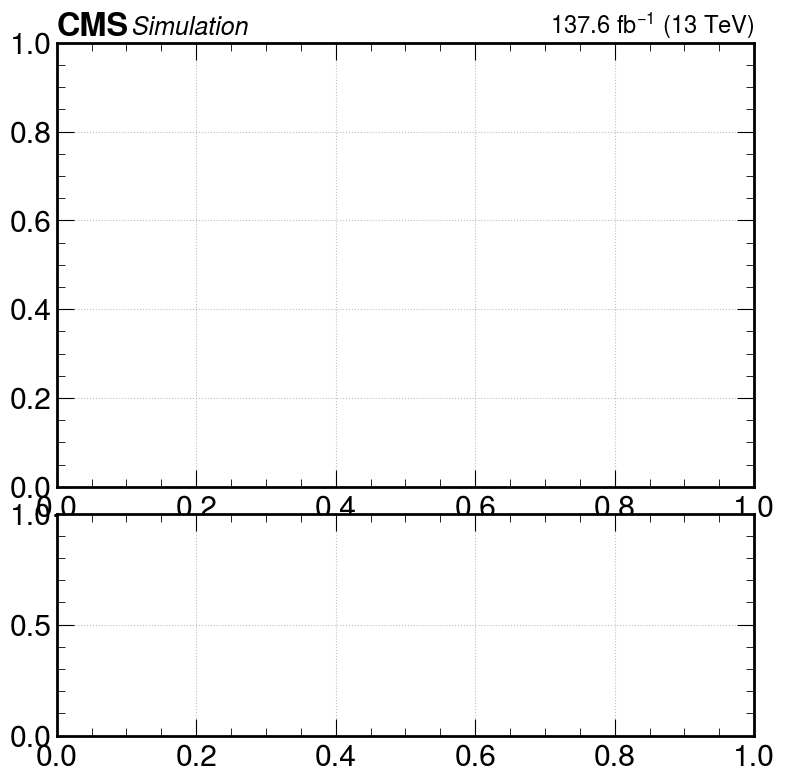

In [ ]:
plot_pull(signal_strength['1'], signal_strength_err['1'], r_gen=1, plot_name='signal_injection_r=1')

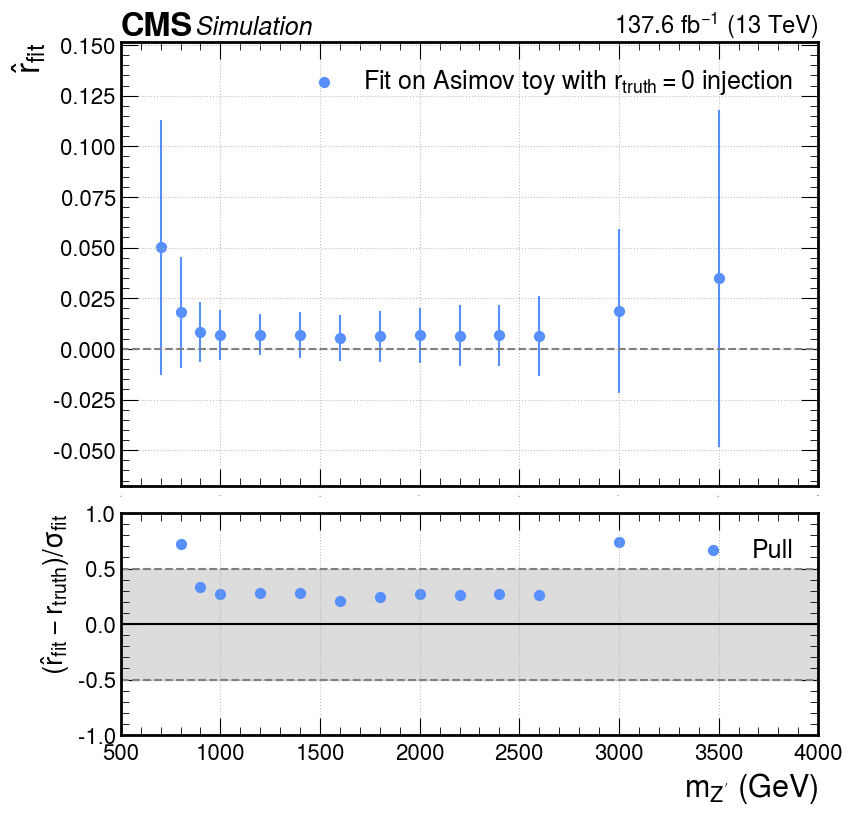

In [74]:
plot_pull(signal_strength['0'], signal_strength_err['0'], r_gen=0, plot_name='signal_injection_r=0')

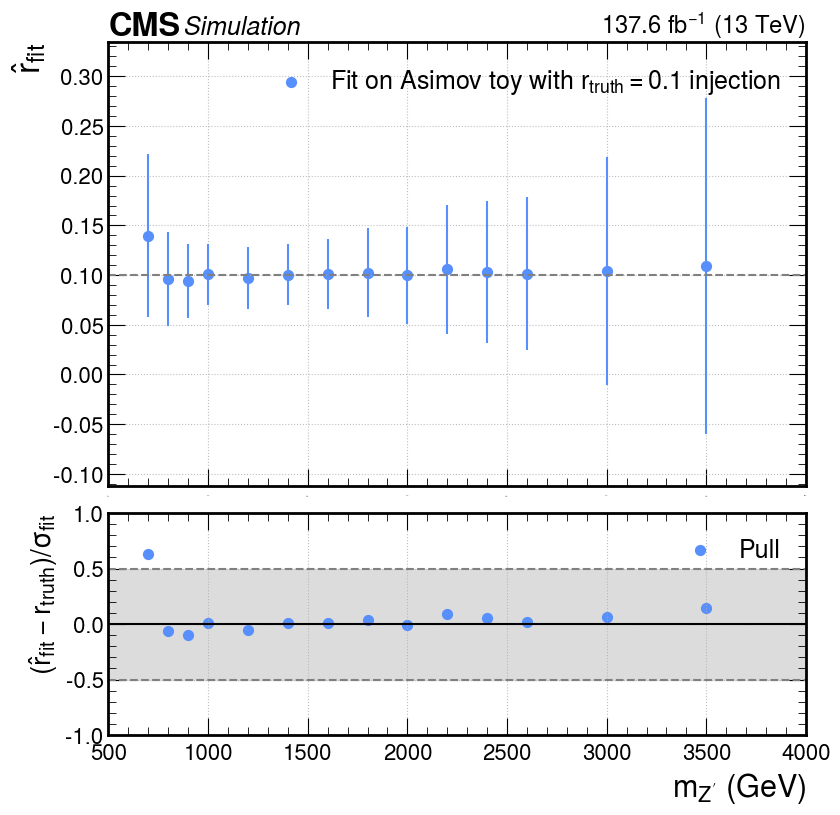

In [75]:
plot_pull(signal_strength['0.1'], signal_strength_err['0.1'], r_gen=0.1, plot_name='signal_injection_r=0.1')

# Cross-section upper limits

In [2]:
#os.chdir('fit')
MASS = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]


In [3]:
from scipy.interpolate import CubicSpline
hep.style.use("CMS")

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)


def plot_cross_section_limit(cross_section_limit, cross_section_nominal=None, x_name='Resonance mass [GeV]', y_name=r'$\sigma[Z^\mathrm{\prime}\to H\gamma]$', SR: str='combine', cuts=None, year='Run2', x_min=500, x_max=4000, y_min=1e-2, postfix=''):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}

    ## canvas initializing
    # colorlist=['red', 'blue', 'green', 'black', 'cyan', 'darkorange', 'darkviolet', 'SlateGray', 'HotPink', 'LightSkyBlue']
    # mpl.rcParams['axes.prop_cycle'] = cycler(color=colorlist)
    f = plt.figure(figsize=(9, 9))
    ax = plt.gca()
    plt.grid()
    hep.cms.label(data=True, ax=ax, fontsize=18, lumi=round(LUMI[year], 1))
        
    ## plot
    signal_mass = list(cross_section_limit.keys())

    x = np.arange(700, 3501, 10)
    plt.fill_between(x,
        CubicSpline(signal_mass, [cross_section_limit[m]['Expected +2sigma'] for m in signal_mass])(x),
        CubicSpline(signal_mass, [cross_section_limit[m]['Expected -2sigma'] for m in signal_mass])(x),
        color='#85D1FBff', label='Expected limit 95% CL'
    )
    plt.fill_between(x, 
        CubicSpline(signal_mass, [cross_section_limit[m]['Expected +1sigma'] for m in signal_mass])(x),
        CubicSpline(signal_mass, [cross_section_limit[m]['Expected -1sigma'] for m in signal_mass])(x),
        color='#FFDF7Fff', label='Expected limit 68% CL'
    )
    plt.plot(x, CubicSpline(signal_mass, [cross_section_limit[m]['Expected Limit'] for m in signal_mass])(x), color='DimGray', label='Expected limit', linestyle='dashed')
    plt.plot(x, CubicSpline(signal_mass, [cross_section_limit[m]['Observed Limit'] for m in signal_mass])(x), color='black', label='Observed limit', linestyle='solid')
    #plt.scatter(signal_mass, [cross_section_limit[m]['Expected Limit'] for m in signal_mass], label='real', c='red')

    """
    plt.fill_between(list(cross_section_limit.keys()), [cross_section_limit[m]['Expected +2sigma'] for m in cross_section_limit], [cross_section_limit[m]['Expected -2sigma'] for m in cross_section_limit], color='#85D1FBff', label='Expected limit 95% CL')
    plt.fill_between(list(cross_section_limit.keys()), [cross_section_limit[m]['Expected +1sigma'] for m in cross_section_limit], [cross_section_limit[m]['Expected -1sigma'] for m in cross_section_limit], color='#FFDF7Fff', label='Expected limit 68% CL')
    plt.plot(list(cross_section_limit.keys()), [cross_section_limit[m]['Expected Limit'] for m in cross_section_limit], color='DimGray', label='Expected limit', linestyle='dashed')
    plt.plot(list(cross_section_limit.keys()), [cross_section_limit[m]['Observed Limit'] for m in cross_section_limit], color='black', label='Observed limit', linestyle='solid')
    """
    if cross_section_nominal is not None:
        plt.scatter(list(cross_section_nominal.keys()), list(cross_section_nominal.values()), label=r'Theory $\sigma(Z^\prime\to H\gamma), c_\gamma=1$', c='black')

    ## axises
    ax.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, ax.get_ylim()[1]*5)
    ax.set_yscale('log')
    #ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    #x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    #y_major_locator=MultipleLocator(1)
    #ax.xaxis.set_major_locator(x_major_locator)
    #ax.yaxis.set_major_locator(y_major_locator)
    ax.set_ylabel('95% CL upper limit on '+y_name+' (fb)', fontsize=20, ha='right', y=1)

    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=22)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    os.makedirs(f'../plots/fit/{year}', exist_ok=True)
    plt.savefig(f"../plots/fit/{year}/{SR}{postfix}_limits.pdf", bbox_inches='tight')
    plt.show()

## Hgamma

In [77]:
rate_limit = {SR: {} for SR in ['SRH1', 'SRH2', 'SRH']} 

for f in os.listdir('./AsymptoticLimits/Run2'):
    if not (f.endswith('.root') and 'AsymptoticLimits' in f):
        continue

    mass, SR = f.split('.')[1:3]
    mass = int(mass.split('_')[0])

    if 'SRH' not in SR:
        continue
    stats = uproot.open(f'./AsymptoticLimits/Run2/{f}')
    limits = stats['limit']['limit'].array()
    rate_limit[SR][int(mass)] = {
        'Expected -2sigma': float(limits[0]),
        'Expected -1sigma': float(limits[1]),
        'Expected Limit': float(limits[2]),
        'Expected +1sigma': float(limits[3]),
        'Expected +2sigma': float(limits[4]),
        'Observed Limit': float(limits[5]),
    }

with open(f'./rate_limit_SRH.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(rate_limit, f)


with open('../src/parameters/cross-section.yaml', 'r', encoding='utf-8') as f:
    cross_section_nominal = yaml.safe_load(f)['ZpToHG']


# convert pb to fb
cross_section_nominal = {int(k.split('_M')[1].split('_')[0]): float(v)*1e3 for k, v in cross_section_nominal.items()}
cs_xsec = CubicSpline(x=list(cross_section_nominal.keys()), y=list(cross_section_nominal.values()))

cross_section_limit = {
    SR: {
        m : {
            limit: rate_limit[SR][m][limit] * cs_xsec(m) for limit in rate_limit[SR][m]
        } for m in range(700, 3501, 50)
    } for SR in rate_limit
}

In [57]:
for m in range(700, 3501, 50):
    if m in MASS:
        continue
    print(f'ZpToHGamma_M{m}: %.4g'%(cs_xsec(m)/1e3))

ZpToHGamma_M750: 0.03399
ZpToHGamma_M850: 0.02742
ZpToHGamma_M950: 0.02226
ZpToHGamma_M1050: 0.01818
ZpToHGamma_M1100: 0.01645
ZpToHGamma_M1150: 0.01489
ZpToHGamma_M1250: 0.01225
ZpToHGamma_M1300: 0.01114
ZpToHGamma_M1350: 0.01013
ZpToHGamma_M1450: 0.008407
ZpToHGamma_M1500: 0.007661
ZpToHGamma_M1550: 0.006985
ZpToHGamma_M1650: 0.005811
ZpToHGamma_M1700: 0.005302
ZpToHGamma_M1750: 0.004841
ZpToHGamma_M1850: 0.004042
ZpToHGamma_M1900: 0.003696
ZpToHGamma_M1950: 0.003381
ZpToHGamma_M2050: 0.002828
ZpToHGamma_M2100: 0.002586
ZpToHGamma_M2150: 0.002363
ZpToHGamma_M2250: 0.001974
ZpToHGamma_M2300: 0.001805
ZpToHGamma_M2350: 0.001651
ZpToHGamma_M2450: 0.001381
ZpToHGamma_M2500: 0.001264
ZpToHGamma_M2550: 0.001156
ZpToHGamma_M2650: 0.0009657
ZpToHGamma_M2700: 0.0008816
ZpToHGamma_M2750: 0.0008042
ZpToHGamma_M2800: 0.0007333
ZpToHGamma_M2850: 0.0006684
ZpToHGamma_M2900: 0.000609
ZpToHGamma_M2950: 0.0005549
ZpToHGamma_M3050: 0.0004607
ZpToHGamma_M3100: 0.0004198
ZpToHGamma_M3150: 0.0003825
ZpTo

In [79]:
import pandas as pd

csv_Hgamma = {
    'mass': [m for m in cross_section_limit['SRH']], 
    'limit_p1': [cross_section_limit['SRH'][m]['Expected +1sigma'] for m in cross_section_limit['SRH']],
    'limit_p2': [cross_section_limit['SRH'][m]['Expected +2sigma'] for m in cross_section_limit['SRH']],
    'limit_m1': [cross_section_limit['SRH'][m]['Expected -1sigma'] for m in cross_section_limit['SRH']],
    'limit_m2': [cross_section_limit['SRH'][m]['Expected -2sigma'] for m in cross_section_limit['SRH']],
    'exp': [cross_section_limit['SRH'][m]['Expected Limit'] for m in cross_section_limit['SRH']],
    'obs': [cross_section_limit['SRH'][m]['Observed Limit'] for m in cross_section_limit['SRH']],
}

df = pd.DataFrame(csv_Hgamma).round(4)
df.to_csv('limit_SRH.csv', index=False, float_format="%.4f")

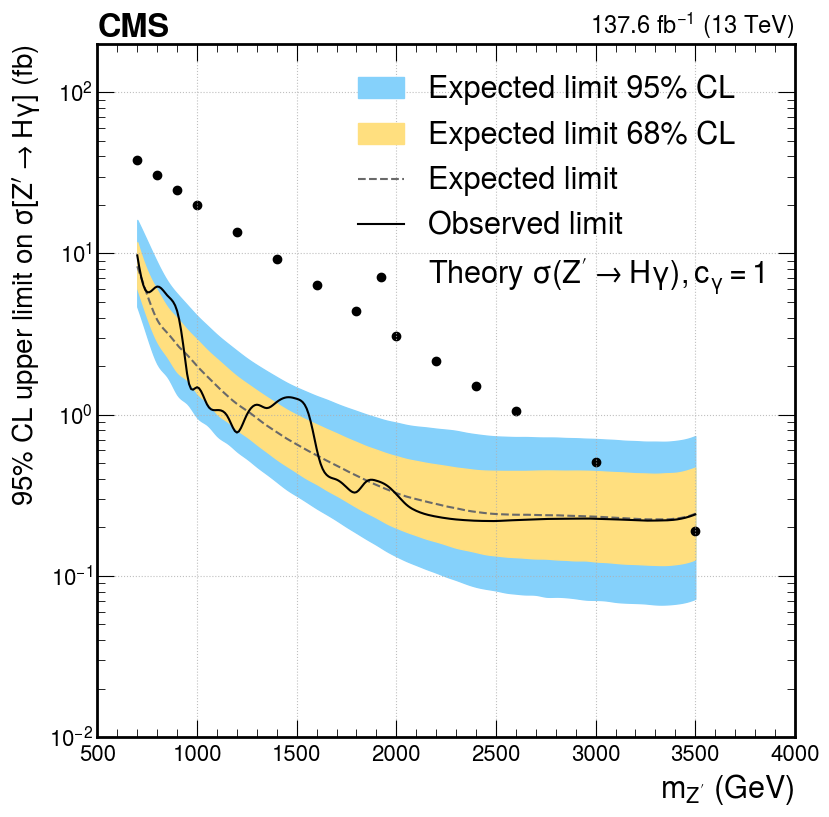

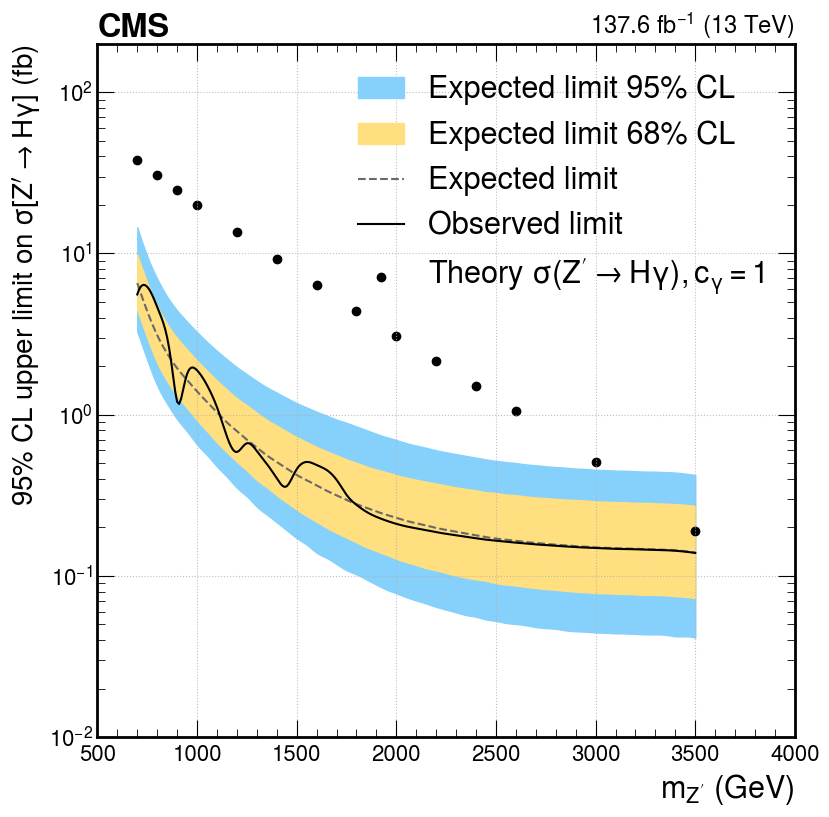

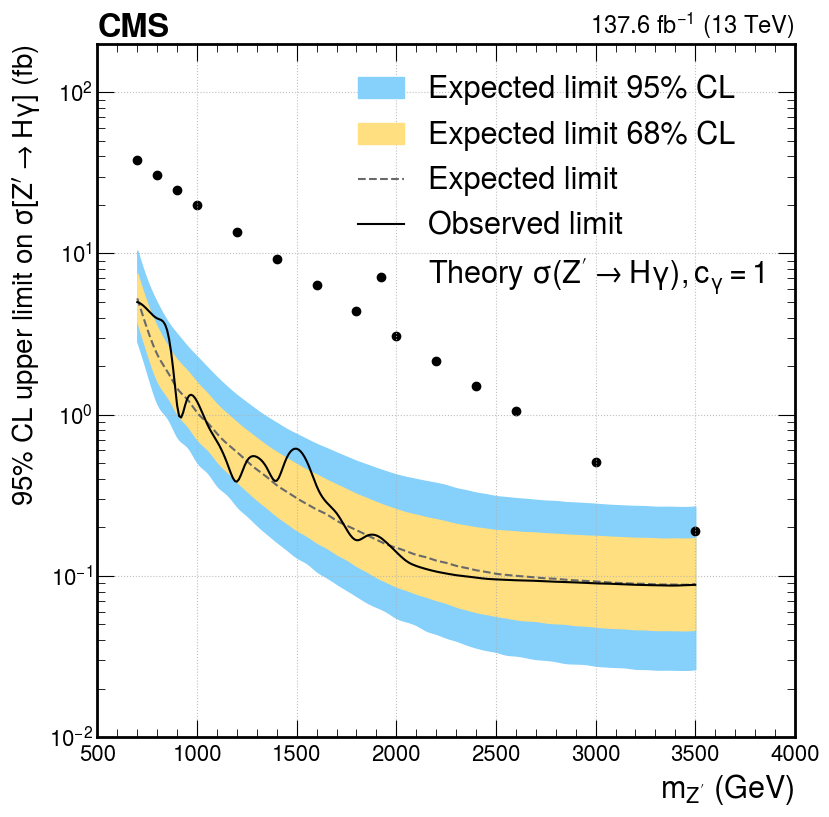

In [19]:
for SR in ['SRH1', 'SRH2', 'SRH']:
    plot_cross_section_limit(cross_section_limit=cross_section_limit[SR], SR=SR, cross_section_nominal=cross_section_nominal, x_name=r'$m_{Z^\prime}$ (GeV)', year='Run2')

### coupling_limit

In [20]:
from scipy.interpolate import CubicSpline

def plot_rate_limit(coupling_limit, SR='combine', x_name='Resonance mass [GeV]', cuts=None, year='2018', x_min=500, x_max=3800):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}

    ## canvas initializing
    # colorlist=['red', 'blue', 'green', 'black', 'cyan', 'darkorange', 'darkviolet', 'SlateGray', 'HotPink', 'LightSkyBlue']
    # mpl.rcParams['axes.prop_cycle'] = cycler(color=colorlist)
    f = plt.figure(figsize=(9, 9))
    ax = plt.gca()
    plt.grid()
    hep.cms.label(data=False, ax=ax, fontsize=18, year=year, lumi=LUMI[year])

    x = np.arange(700, 3501, 10)

    signal_mass = list(coupling_limit.keys())
    ## plot
    plt.fill_between(x,
        CubicSpline(signal_mass, [coupling_limit[m]['Expected +2sigma'] for m in signal_mass])(x),
        CubicSpline(signal_mass, [coupling_limit[m]['Expected -2sigma'] for m in signal_mass])(x),
        color='#85D1FBff', label='Expected limit 95% CL'
    )
    plt.fill_between(x, 
        CubicSpline(signal_mass, [coupling_limit[m]['Expected +1sigma'] for m in signal_mass])(x),
        CubicSpline(signal_mass, [coupling_limit[m]['Expected -1sigma'] for m in signal_mass])(x),
        color='#FFDF7Fff', label='Expected limit 68% CL'
    )
    plt.plot(x, CubicSpline(signal_mass, [coupling_limit[m]['Expected Limit'] for m in signal_mass])(x), color='DimGray', label='Expected limit', linestyle='dashed')
    plt.plot(x, CubicSpline(signal_mass, [coupling_limit[m]['Observed Limit'] for m in signal_mass])(x), color='black', label='Observed limit', linestyle='solid')
    plt.plot([x_min, x_max], [1, 1], c='black', label=r'Theory coupling $c_\gamma=1$')

    ## axises
    ax.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(1e-1, ax.get_ylim()[1]*5)
    ax.set_yscale('log')
    #ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    #x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    #y_major_locator=MultipleLocator(1)
    #ax.xaxis.set_major_locator(x_major_locator)
    #ax.yaxis.set_major_locator(y_major_locator)
    ax.set_ylabel(r'95% CL upper limit on coupling $c_\gamma$', fontsize=20, ha='right', y=1)

    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=22)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    if not os.path.exists(f'../plots/fit/{year}'):
        os.makedirs(f'../plots/fit/{year}')
    plt.savefig(f"../plots/fit/{year}/{SR}_limit_coupling.pdf", bbox_inches='tight')
    plt.show()

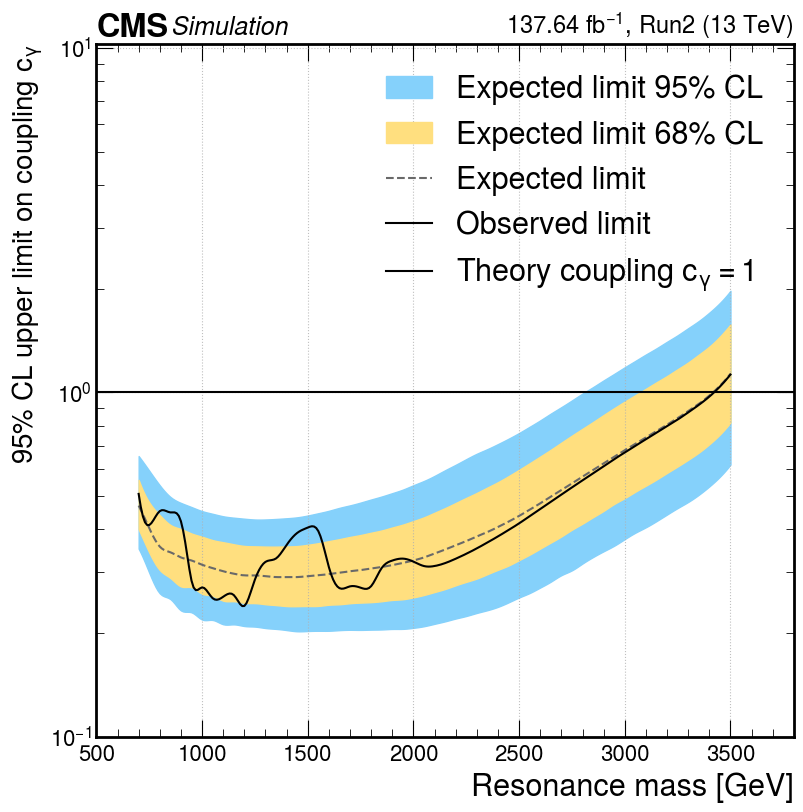

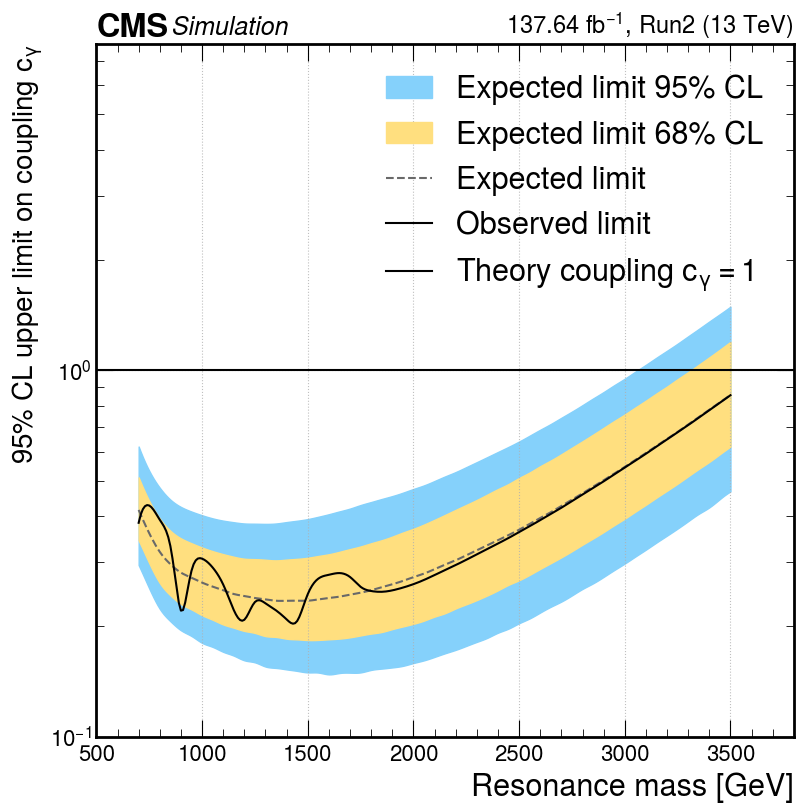

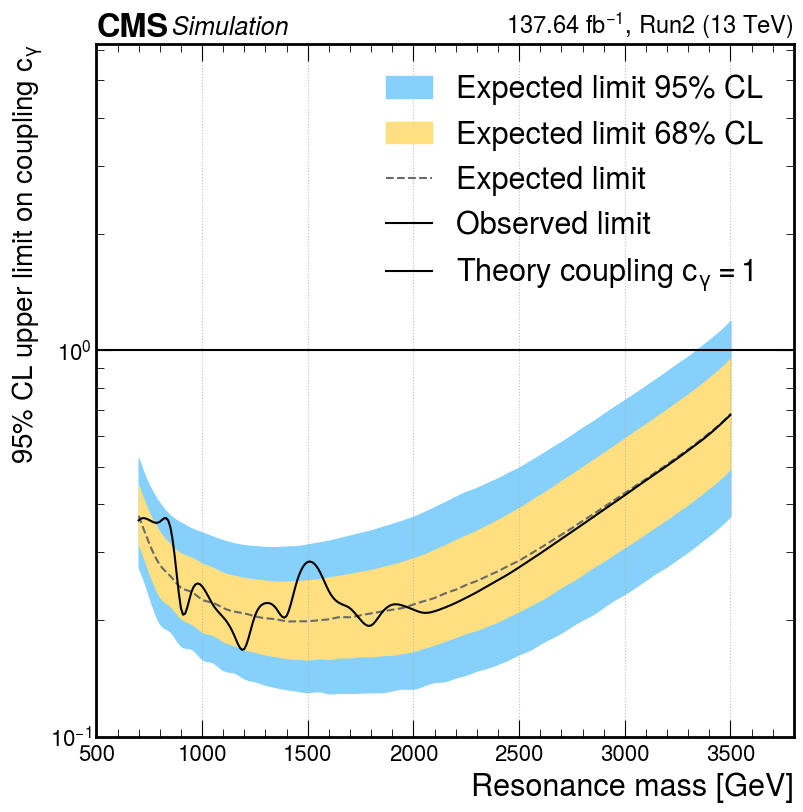

In [21]:
for SR in ['SRH1', 'SRH2', 'SRH']:
    plot_rate_limit(coupling_limit={m: {k: np.sqrt(rate_limit[SR][m][k]) for k in rate_limit[SR][m]} for m in range(700, 3501, 50)}, year='Run2', SR=SR)

## Zgamma

### narrow

In [75]:
MASS = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]

rate_limit = {SR: {} for SR in ['SRZ1', 'SRZ2', 'SRZ']} 

width='0p014'
for f in os.listdir('./AsymptoticLimits/Run2'):
    if not (f.endswith('.root') and 'AsymptoticLimits' in f):
        continue

    mass, SR = f.split('.')[1:3]
    if '_' in mass:
        continue
    mass = int(mass)

    if 'SRZ' not in SR:
        continue

    stats = uproot.open(f'./AsymptoticLimits/Run2/{f}')
    limits = stats['limit']['limit'].array()
    rate_limit[SR][int(mass)] = {
        'Expected -2sigma': float(limits[0]),
        'Expected -1sigma': float(limits[1]),
        'Expected Limit': float(limits[2]),
        'Expected +1sigma': float(limits[3]),
        'Expected +2sigma': float(limits[4]),
        'Observed Limit': float(limits[5]),
    }


with open(f'./rate_limit_SRZ.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(rate_limit, f)

with open(f'./rate_limit_SRZ.yaml', 'r', encoding='utf-8') as f:
    rate_limit=yaml.safe_load(f)

with open('../src/parameters/cross-section.yaml', 'r', encoding='utf-8') as f:
    cross_section_nominal = yaml.safe_load(f)['GluGluToZG']


cross_section_limit = {
    SR: {
        m : {
            limit: rate_limit[SR][m][limit] * 1 for limit in rate_limit[SR][m]
        } for m in range(700, 3501, 50)
    } for SR in rate_limit
}

In [76]:
import pandas as pd

csv_Zgamma = {
    'mass': [m for m in cross_section_limit['SRZ']], 
    'limit_p1': [cross_section_limit['SRZ'][m]['Expected +1sigma'] for m in cross_section_limit['SRZ']],
    'limit_p2': [cross_section_limit['SRZ'][m]['Expected +2sigma'] for m in cross_section_limit['SRZ']],
    'limit_m1': [cross_section_limit['SRZ'][m]['Expected -1sigma'] for m in cross_section_limit['SRZ']],
    'limit_m2': [cross_section_limit['SRZ'][m]['Expected -2sigma'] for m in cross_section_limit['SRZ']],
    'exp': [cross_section_limit['SRZ'][m]['Expected Limit'] for m in cross_section_limit['SRZ']],
    'obs': [cross_section_limit['SRZ'][m]['Observed Limit'] for m in cross_section_limit['SRZ']],
}

df = pd.DataFrame(csv_Zgamma).round(4)
df.to_csv('limit_SRZ_narrow.csv', index=False, float_format="%.4f")

In [ ]:
for SR in ['SRZ1', 'SRZ2', 'SRZ']:
    plot_cross_section_limit(cross_section_limit=cross_section_limit[SR], cross_section_nominal=None, SR=SR, x_name=r'$m_S$ (GeV)', y_name=r'$\sigma[S\to Z\gamma]$', year='Run2')

### wide

In [73]:
MASS = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]

rate_limit = {SR: {} for SR in ['SRZ1', 'SRZ2', 'SRZ']} 

width='5p6'
for f in os.listdir('./AsymptoticLimits/Run2'):
    if not (f.endswith('.root') and 'AsymptoticLimits' in f and width in f):
        continue

    mass, SR = f.split('.')[1:3]
    if '_5p6' not in mass:
        continue
    mass = int(mass.split('_')[0])

    if 'SRZ' not in SR:
        continue

    stats = uproot.open(f'./AsymptoticLimits/Run2/{f}')
    limits = stats['limit']['limit'].array()
    rate_limit[SR][int(mass)] = {
        'Expected -2sigma': float(limits[0]),
        'Expected -1sigma': float(limits[1]),
        'Expected Limit': float(limits[2]),
        'Expected +1sigma': float(limits[3]),
        'Expected +2sigma': float(limits[4]),
        'Observed Limit': float(limits[5]),
    }


with open(f'./rate_limit_SRZ_{width}.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(rate_limit, f)

with open(f'./rate_limit_SRZ_{width}.yaml', 'r', encoding='utf-8') as f:
    rate_limit=yaml.safe_load(f)

cross_section_limit = {
    SR: {
        m : {
            limit: rate_limit[SR][m][limit] * 1 for limit in rate_limit[SR][m]
        } for m in range(700, 3501, 50)
    } for SR in rate_limit
}


In [74]:
import pandas as pd

csv_Zgamma = {
    'mass': [m for m in cross_section_limit['SRZ']], 
    'limit_p1': [cross_section_limit['SRZ'][m]['Expected +1sigma'] for m in cross_section_limit['SRZ']],
    'limit_p2': [cross_section_limit['SRZ'][m]['Expected +2sigma'] for m in cross_section_limit['SRZ']],
    'limit_m1': [cross_section_limit['SRZ'][m]['Expected -1sigma'] for m in cross_section_limit['SRZ']],
    'limit_m2': [cross_section_limit['SRZ'][m]['Expected -2sigma'] for m in cross_section_limit['SRZ']],
    'exp': [cross_section_limit['SRZ'][m]['Expected Limit'] for m in cross_section_limit['SRZ']],
    'obs': [cross_section_limit['SRZ'][m]['Observed Limit'] for m in cross_section_limit['SRZ']],
}

df = pd.DataFrame(csv_Zgamma).round(4)
df.to_csv('limit_SRZ_wide.csv', index=False, float_format="%.4f")

In [ ]:
for SR in ['SRZ1', 'SRZ2', 'SRZ']:
    plot_cross_section_limit(cross_section_limit=cross_section_limit[SR], SR=SR, x_name=r'$m_S$ (GeV)', y_name=r'$\sigma[S\to Z\gamma]$', year='Run2', y_min=1e-1, postfix='_5p6')

### very wide

In [71]:
rate_limit = {SR: {} for SR in ['SRZ1', 'SRZ2', 'SRZ']} 
width='10p0'
for f in os.listdir('./AsymptoticLimits/Run2'):
    if not (f.endswith('.root') and 'AsymptoticLimits' in f and width in f):
        continue

    mass, SR = f.split('.')[1:3]
    if '_10p0' not in mass:
        continue
    mass = int(mass.split('_')[0])

    if 'SRZ' not in SR:
        continue


    stats = uproot.open(f'./AsymptoticLimits/Run2/{f}')
    limits = stats['limit']['limit'].array()
    rate_limit[SR][int(mass)] = {
        'Expected -2sigma': float(limits[0]),
        'Expected -1sigma': float(limits[1]),
        'Expected Limit': float(limits[2]),
        'Expected +1sigma': float(limits[3]),
        'Expected +2sigma': float(limits[4]),
        'Observed Limit': float(limits[5]),
    }



with open(f'./rate_limit_SRZ_{width}.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(rate_limit, f)

with open(f'./rate_limit_SRZ_{width}.yaml', 'r', encoding='utf-8') as f:
    rate_limit=yaml.safe_load(f)

with open('../src/parameters/cross-section.yaml', 'r', encoding='utf-8') as f:
    cross_section_nominal = yaml.safe_load(f)['GluGluToZG']


cross_section_limit = {
    SR: {
        m : {
            limit: rate_limit[SR][m][limit] * 1 for limit in rate_limit[SR][m]
        } for m in range(700, 3501, 50)
    } for SR in rate_limit
}

In [72]:
import pandas as pd

csv_Zgamma = {
    'mass': [m for m in cross_section_limit['SRZ']], 
    'limit_p1': [cross_section_limit['SRZ'][m]['Expected +1sigma'] for m in cross_section_limit['SRZ']],
    'limit_p2': [cross_section_limit['SRZ'][m]['Expected +2sigma'] for m in cross_section_limit['SRZ']],
    'limit_m1': [cross_section_limit['SRZ'][m]['Expected -1sigma'] for m in cross_section_limit['SRZ']],
    'limit_m2': [cross_section_limit['SRZ'][m]['Expected -2sigma'] for m in cross_section_limit['SRZ']],
    'exp': [cross_section_limit['SRZ'][m]['Expected Limit'] for m in cross_section_limit['SRZ']],
    'obs': [cross_section_limit['SRZ'][m]['Observed Limit'] for m in cross_section_limit['SRZ']],
}

df = pd.DataFrame(csv_Zgamma).round(4)
df.to_csv('limit_SRZ_very_wide.csv', index=False, float_format="%.4f")

In [ ]:
for SR in ['SRZ1', 'SRZ2', 'SRZ']:
    plot_cross_section_limit(cross_section_limit=cross_section_limit[SR], SR=SR, x_name=r'$m_S$ (GeV)', y_name=r'$\sigma[S\to Z\gamma]$', year='Run2', y_min=1e-1, postfix='_10p0')

# Significance

## Hgamma

In [141]:
significance = {'expected': {}, 'observed': {}} 
signal_region = 'SRH'

for f in os.listdir('./Significance/observed'):
    if not (f.endswith('.root') and 'Significance' in f):
        continue
    mass, SR = f.split('.')[1:3]
    if SR !=signal_region or '_' in mass:
        continue
    mass = int(mass.split('_')[0])
    stats = uproot.open(f'./Significance/observed/{f}')
    limits = stats['limit']['limit'].array()
    significance['observed'][int(mass)] = float(limits[0])

for f in os.listdir('./Significance/expected'):
    if not (f.endswith('.root') and 'Significance' in f):
        continue
    mass, SR = f.split('.')[1:3]
    if SR !=signal_region or '_' in mass:
        continue
    mass = int(mass.split('_')[0])
    stats = uproot.open(f'./Significance/expected/{f}')
    limits = stats['limit']['limit'].array()
    significance['expected'][int(mass)] = float(limits[0])


for i in range(19):
    a=700+50*i
    b=700+50*(i+19)
    c=700+50*(i+38)
    print(f"{a} & {round(significance['expected'][a],3)} & {round(significance['observed'][a],3)} & {b} & {round(significance['expected'][b],3)} & {round(significance['observed'][b],3)} & {c} & {round(significance['expected'][c],3)} & {round(significance['observed'][c],3)} \\\\")

700 & 10.237 & 0.0 & 1650 & 21.611 & 0.743 & 2600 & 11.445 & 0.0 \\
750 & 13.619 & 0.705 & 1700 & 21.078 & 0.07 & 2650 & 10.96 & 0.0 \\
800 & 15.954 & 1.464 & 1750 & 20.522 & 0.0 & 2700 & 10.494 & 0.0 \\
850 & 18.078 & 1.049 & 1800 & 20.002 & 0.0 & 2750 & 10.044 & 0.0 \\
900 & 19.278 & 0.0 & 1850 & 19.46 & 0.0 & 2800 & 9.607 & 0.0 \\
950 & 20.689 & 0.085 & 1900 & 18.952 & 0.0 & 2850 & 9.189 & 0.0 \\
1000 & 21.518 & 0.709 & 1950 & 18.403 & 0.0 & 2900 & 8.78 & 0.0 \\
1050 & 22.521 & 0.0 & 2000 & 17.854 & 0.0 & 2950 & 8.386 & 0.0 \\
1100 & 23.1 & 0.0 & 2050 & 17.252 & 0.0 & 3000 & 8.003 & 0.0 \\
1150 & 23.738 & 0.0 & 2100 & 16.652 & 0.0 & 3050 & 7.633 & 0.0 \\
1200 & 24.09 & 0.0 & 2150 & 16.043 & 0.0 & 3100 & 7.277 & 0.0 \\
1250 & 24.411 & 0.243 & 2200 & 15.471 & 0.0 & 3150 & 6.933 & 0.0 \\
1300 & 24.549 & 0.514 & 2250 & 14.927 & 0.0 & 3200 & 6.599 & 0.0 \\
1350 & 24.511 & 0.0 & 2300 & 14.423 & 0.0 & 3250 & 6.282 & 0.0 \\
1400 & 24.224 & 0.0 & 2350 & 13.928 & 0.0 & 3300 & 5.981 & 0.0 \\
1

## Zgamma narrow

In [144]:
significance = {'expected': {}, 'observed': {}} 
signal_region = 'SRZ2'

for f in os.listdir('./Significance/observed'):
    if not (f.endswith('.root') and 'Significance' in f):
        continue
    mass, SR = f.split('.')[1:3]
    if SR !=signal_region or '_' in mass:
        continue
    mass = int(mass.split('_')[0])
    stats = uproot.open(f'./Significance/observed/{f}')
    limits = stats['limit']['limit'].array()
    significance['observed'][int(mass)] = float(limits[0])

for f in os.listdir('./Significance/expected'):
    if not (f.endswith('.root') and 'Significance' in f):
        continue
    mass, SR = f.split('.')[1:3]
    if SR !=signal_region or '_' in mass:
        continue
    mass = int(mass.split('_')[0])
    stats = uproot.open(f'./Significance/expected/{f}')
    limits = stats['limit']['limit'].array()
    significance['expected'][int(mass)] = float(limits[0])


for i in range(19):
    a=700+50*i
    b=700+50*(i+19)
    c=700+50*(i+38)
    print(f"{a} & {round(significance['expected'][a],3)} & {round(significance['observed'][a],3)} & {b} & {round(significance['expected'][b],3)} & {round(significance['observed'][b],3)} & {c} & {round(significance['expected'][c],3)} & {round(significance['observed'][c],3)} \\\\")

700 & 0.134 & 0.196 & 1650 & 2.47 & 0.665 & 2600 & 4.668 & 0.0 \\
750 & 0.264 & 0.454 & 1700 & 2.605 & 1.674 & 2650 & 4.752 & 0.0 \\
800 & 0.286 & 0.0 & 1750 & 2.733 & 2.16 & 2700 & 4.84 & 0.0 \\
850 & 0.38 & 0.0 & 1800 & 2.877 & 2.029 & 2750 & 4.922 & 0.0 \\
900 & 0.417 & 0.0 & 1850 & 3.017 & 1.527 & 2800 & 5.006 & 0.0 \\
950 & 0.556 & 0.0 & 1900 & 3.166 & 0.616 & 2850 & 5.083 & 0.0 \\
1000 & 0.656 & 0.979 & 1950 & 3.299 & 0.0 & 2900 & 5.161 & 0.0 \\
1050 & 0.766 & 1.386 & 2000 & 3.429 & 0.0 & 2950 & 5.231 & 0.0 \\
1100 & 0.884 & 0.988 & 2050 & 3.541 & 0.0 & 3000 & 5.302 & 0.0 \\
1150 & 1.014 & 0.0 & 2100 & 3.651 & 0.0 & 3050 & 5.365 & 0.0 \\
1200 & 1.144 & 0.0 & 2150 & 3.752 & 0.0 & 3100 & 5.427 & 0.0 \\
1250 & 1.303 & 0.727 & 2200 & 3.855 & 0.0 & 3150 & 5.485 & 0.0 \\
1300 & 1.435 & 0.419 & 2250 & 3.964 & 0.0 & 3200 & 5.542 & 0.0 \\
1350 & 1.6 & 0.0 & 2300 & 4.072 & 0.0 & 3250 & 5.596 & 0.0 \\
1400 & 1.749 & 0.0 & 2350 & 4.18 & 0.0 & 3300 & 5.651 & 0.0 \\
1450 & 1.914 & 0.0 & 2400 &

## Zgamma wide

In [ ]:
significance = {'expected': {}, 'observed': {}} 
signal_region = 'SRZ'

for f in os.listdir('./Significance/observed'):
    if not (f.endswith('.root') and 'Significance' in f):
        continue
    mass, SR = f.split('.')[1:3]
    if SR != signal_region or '_5p6' not in mass:
        continue
    mass = int(mass.split('_')[0])
    stats = uproot.open(f'./Significance/observed/{f}')
    limits = stats['limit']['limit'].array()
    significance['observed'][int(mass)] = float(limits[0])

for f in os.listdir('./Significance/expected'):
    if not (f.endswith('.root') and 'Significance' in f):
        continue
    mass, SR = f.split('.')[1:3]
    if SR != signal_region or '_5p6' not in mass:
        continue
    mass = int(mass.split('_')[0])
    stats = uproot.open(f'./Significance/expected/{f}')
    limits = stats['limit']['limit'].array()
    significance['expected'][int(mass)] = float(limits[0])


for i in range(19):
    a=700+50*i
    b=700+50*(i+19)
    c=700+50*(i+38)
    print(f"{a} & {round(significance['expected'][a],3)} & {round(significance['observed'][a],3)} & {b} & {round(significance['expected'][b],3)} & {round(significance['observed'][b],3)} & {c} & {round(significance['expected'][c],3)} & {round(significance['observed'][c],3)} \\\\")

## Zgamma very wide

In [ ]:
significance = {'expected': {}, 'observed': {}} 
signal_region = 'SRZ'

for f in os.listdir('./Significance/observed'):
    if not (f.endswith('.root') and 'Significance' in f):
        continue
    mass, SR = f.split('.')[1:3]
    if SR != signal_region or '_10p0' not in mass:
        continue
    mass = int(mass.split('_')[0])
    stats = uproot.open(f'./Significance/observed/{f}')
    limits = stats['limit']['limit'].array()
    significance['observed'][int(mass)] = float(limits[0])

for f in os.listdir('./Significance/expected'):
    if not (f.endswith('.root') and 'Significance' in f):
        continue
    mass, SR = f.split('.')[1:3]
    if SR != signal_region or '_10p0' not in mass:
        continue
    mass = int(mass.split('_')[0])
    stats = uproot.open(f'./Significance/expected/{f}')
    limits = stats['limit']['limit'].array()
    significance['expected'][int(mass)] = float(limits[0])


for i in range(19):
    a=700+50*i
    b=700+50*(i+19)
    c=700+50*(i+38)
    print(f"{a} & {round(significance['expected'][a],3)} & {round(significance['observed'][a],3)} & {b} & {round(significance['expected'][b],3)} & {round(significance['observed'][b],3)} & {c} & {round(significance['expected'][c],3)} & {round(significance['observed'][c],3)} \\\\")

# Deficit

## Hgamma

In [ ]:
signal_region = 'SRH'
deficit = {}
for f in os.listdir('./MultiDimFit/Asimov'):
    if not (f.endswith('.root') and 'MultiDimFit' in f):
        continue

    mass, SR = f.split('.')[1:3]
    mass = int(mass.split('_')[0])

    if SR != signal_region:
        continue
    stats = uproot.open(f'./MultiDimFit/Asimov/{f}')
    r = stats['limit']['r'].array()
    deficit[mass] = r[0]*2/(r[2]-r[1])
    print(r, deficit[mass])



print(min(deficit.values()))

In [ ]:
for m in deficit:
    if deficit[m]< 0:
        print(m, deficit[m])

## Zgamma narrow

In [ ]:
signal_region = 'SRZ'
deficit = {}
for f in os.listdir('./MultiDimFit/Asimov'):
    if not (f.endswith('.root') and 'MultiDimFit' in f):
        continue

    mass, SR = f.split('.')[1:3]
    if SR != signal_region or '_' in mass:
        continue
    mass = int(mass.split('_')[0])
    
    stats = uproot.open(f'./MultiDimFit/Asimov/{f}')
    r = stats['limit']['r'].array()
    deficit[mass] = r[0]*2/(r[2]-r[1])
    #print(r)

print(min(deficit.values()))

In [ ]:
for m in deficit:
    if deficit[m] <= 0:
        print(m, deficit[m])

## Zgamma wide

In [ ]:
signal_region = 'SRZ'
deficit = {}
for f in os.listdir('./MultiDimFit'):
    if not (f.endswith('.root') and 'MultiDimFit' in f):
        continue

    mass, SR = f.split('.')[1:3]
    if SR != signal_region or '_5p6' not in mass:
        continue
    mass = int(mass.split('_')[0])

    stats = uproot.open(f'./MultiDimFit/{f}')
    r = stats['limit']['r'].array()
    deficit[mass] = (r[0]-0)#*2/(r[2] - r[1])
    #print(r)

print(min(deficit.values()))

In [ ]:
for m in deficit:
    if deficit[m]<= min(deficit.values()):
        print(m, deficit[m])

## Zgamma very wide

In [ ]:
signal_region = 'SRZ'
deficit = {}
for f in os.listdir('./MultiDimFit'):
    if not (f.endswith('.root') and 'MultiDimFit' in f):
        continue

    mass, SR = f.split('.')[1:3]
    if SR != signal_region or '_10p0' not in mass:
        continue
    mass = int(mass.split('_')[0])
    
    stats = uproot.open(f'./MultiDimFit/{f}')
    r = stats['limit']['r'].array()
    deficit[mass] = (r[0]-0)#*2/(r[2] - r[1])
    #print(r)

print(min(deficit.values()))

# postfit

In [4]:
import ROOT


Welcome to JupyROOT 6.30/07


In [8]:
def postfit(file, mass, SR):
    f = ROOT.TFile(file)
    m = str(mass).split('_')[0]
    w = f.Get("w")
    w.Print("v")

    n_bins = (3700-650)//50
    binning = ROOT.RooFit.Binning(n_bins,650,3700)

    can = ROOT.TCanvas()
    plot = w.var("fit_mass").frame()

    w.data("data_obs").plotOn(plot, binning)

    # Load the S+B model
    sb_model = w.pdf("model_s").getPdf(SR)
    if '_5p6' in str(mass):
        width = ' (wide)'
    elif '_10p0' in str(mass):
        width = ' (very wide)'
    else:
        width = ' (narrow)'
    plot.SetTitle("signal of m="+m+"GeV"+width+" in "+SR)

    # Prefit
    #sb_model.plotOn(plot, ROOT.RooFit.LineColor(2), ROOT.RooFit.Name("prefit"))

    # Postfit
    w.loadSnapshot("MultiDimFit")
    sb_model.plotOn(plot, ROOT.RooFit.LineColor(4), ROOT.RooFit.Name("postfit"))
    r_bestfit = w.var("r").getVal()

    plot.Draw()

    leg = ROOT.TLegend(0.55,0.6,0.85,0.85)
    #leg.AddEntry("prefit", "Prefit S+B model (r=1.00)", "L")
    leg.AddEntry("postfit", "Postfit S+B model (r=%.2f)"%r_bestfit, "L")
    leg.Draw("Same")

    can.Update()
    can.SetLogy()
    os.makedirs('../plots/fit/Run2/', exist_ok=True)
    can.SaveAs(f"../plots/fit/Run2/postfit_{mass}_{SR}.pdf")

In [10]:
postfit('./higgsCombine.1550.SRH.MultiDimFit.mH120.root', 1550, 'SRH1')
postfit('./higgsCombine.1550.SRH.MultiDimFit.mH120.root', 1550, 'SRH2')

postfit('./higgsCombine.1750.SRZ.MultiDimFit.mH120.root', 1750, 'SRZ1')
postfit('./higgsCombine.1750.SRZ.MultiDimFit.mH120.root', 1750, 'SRZ2')

postfit('./higgsCombine.1750_5p6.SRZ.MultiDimFit.mH120.root', '1750_5p6', 'SRZ1')
postfit('./higgsCombine.1750_5p6.SRZ.MultiDimFit.mH120.root', '1750_5p6', 'SRZ2')

postfit('./higgsCombine.1750_10p0.SRZ.MultiDimFit.mH120.root', '1750_10p0', 'SRZ1')
postfit('./higgsCombine.1750_10p0.SRZ.MultiDimFit.mH120.root', '1750_10p0', 'SRZ2')



RooWorkspace(w) w contents

variables
---------
(Br_Hbb,Br_Hbb_In,CMS_channel,CSEV,CSEV_In,JER,JER_In,JES_2016,JES_2016_In,JES_2017,JES_2017_In,JES_2018,JES_2018_In,L1_prefiring,L1_prefiring_In,MH,PDF,PDF_In,PER,PER_In,PES,PES_In,QCD_scale,QCD_scale_In,Xbb_tagger_SR1,Xbb_tagger_SR1_In,Xbb_tagger_SR2,Xbb_tagger_SR2_In,alphaL,alphaR,fit_mass,jet_mass,lumi_13TeV_1718,lumi_13TeV_1718_In,lumi_13TeV_2016,lumi_13TeV_2016_In,lumi_13TeV_2017,lumi_13TeV_2017_In,lumi_13TeV_2018,lumi_13TeV_2018_In,lumi_13TeV_correlated,lumi_13TeV_correlated_In,nL,nR,n_exp_binSRH1_proc_background,n_exp_binSRH2_proc_background,p1_dijet2,p1_dijet3,p1_expow1,p1_expow2,p1_invpow2,p1_invpow3,p2_dijet2,p2_dijet3,p2_expow2,p2_invpow2,p2_invpow3,p3_dijet3,p3_invpow3,pdfindex_SRH1,pdfindex_SRH2,photon_ID,photon_ID_In,pile-up,pile-up_In,r,shapeBkg_background_SRH1__norm,shapeBkg_background_SRH2__norm,sigmaL,sigmaR,tagger,x0)

p.d.f.s
-------
SimpleGaussianConstraint::Br_Hbb_Pdf[ x=Br_Hbb mean=Br_Hbb_In sigma=1 ] = 1
SimpleGa

Info in <TCanvas::Print>: pdf file ../plots/fit/Run2/postfit_1550_SRH1.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/fit/Run2/postfit_1550_SRH2.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/fit/Run2/postfit_1750_SRZ1.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/fit/Run2/postfit_1750_SRZ2.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/fit/Run2/postfit_1750_5p6_SRZ1.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/fit/Run2/postfit_1750_5p6_SRZ2.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/fit/Run2/postfit_1750_10p0_SRZ1.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/fit/Run2/postfit_1750_10p0_SRZ2.pdf has been created


# likelihood

 <<< Combine >>> 
 <<< v10.0.2 >>>
>>> Random number generator seed is 123456
>>> Method used is MultiDimFit
Set Range of Parameter r To : (0,2)
Set Default Index of Parameter pdfindex_SRH1 To : -1 (was: 0 )
[#0] ERROR:InputArguments -- RooCategory: Trying to set invalid state -1 for category pdfindex_SRH1
Doing initial fit: 
 POI: r= 1.46372e-13 -> [0,2]
Point 0/50 r = 0.02
Point 1/50 r = 0.06
Point 2/50 r = 0.1
Point 3/50 r = 0.14
Point 4/50 r = 0.18
Point 5/50 r = 0.22
Point 6/50 r = 0.26
Point 7/50 r = 0.3
Point 8/50 r = 0.34
Point 9/50 r = 0.38
Point 10/50 r = 0.42
Point 11/50 r = 0.46
Point 12/50 r = 0.5
Point 13/50 r = 0.54
Point 14/50 r = 0.58
Point 15/50 r = 0.62
Point 16/50 r = 0.66
Point 17/50 r = 0.7
Point 18/50 r = 0.74
Point 19/50 r = 0.78
Point 20/50 r = 0.82
Point 21/50 r = 0.86
Point 22/50 r = 0.9
Point 23/50 r = 0.94
Point 24/50 r = 0.98
Point 25/50 r = 1.02
Point 26/50 r = 1.06
Point 27/50 r = 1.1
Point 28/50 r = 1.14
Point 29/50 r = 1.18
Point 30/50 r = 1.22
Point 3

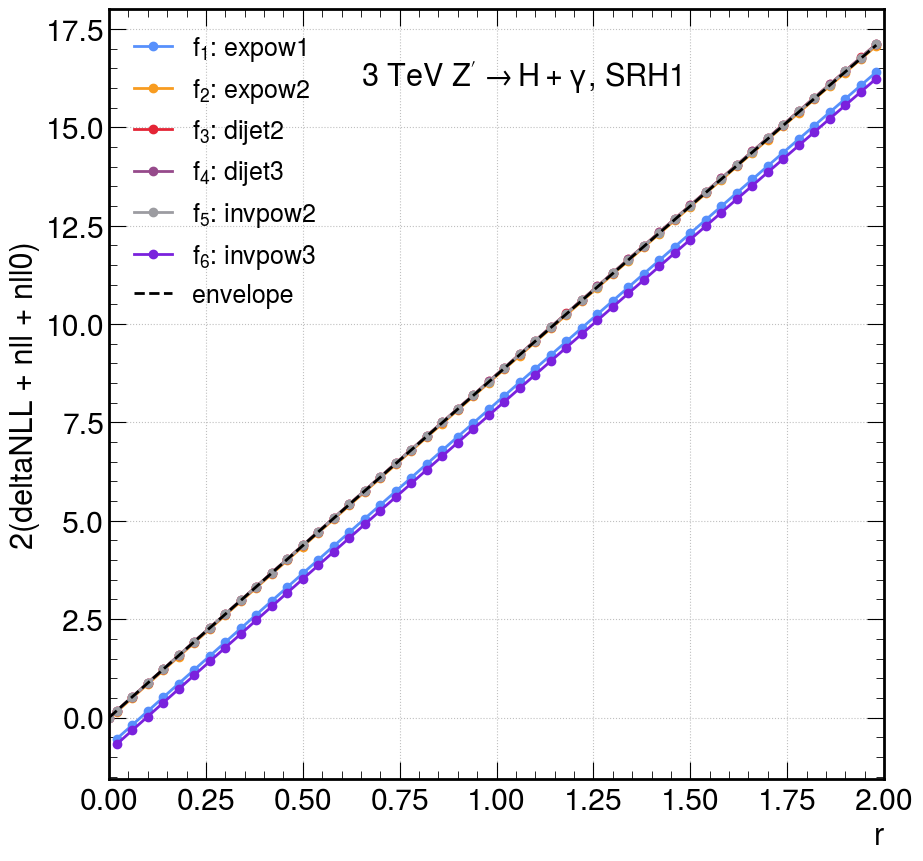

In [2]:
result = {}
os.system("combine -M MultiDimFit -d datacard/Run2/3000/SRH1.txt --algo grid --setParameterRanges r=0,2 --cminDefaultMinimizerStrategy 0 --saveNLL -n .envelope -m 125 --setParameters pdfindex_SRH1=-1 --X-rtd REMOVE_CONSTANT_ZERO_POINT=1")
result['envelope'] = uproot.open('higgsCombine.envelope.MultiDimFit.mH125.root')
function = {
    0: r'$f_1$: expow1',
    1: r'$f_2$: expow2',
    2: r'$f_3$: dijet2',
    3: r'$f_4$: dijet3',
    4: r'$f_5$: invpow2',
    5: r'$f_6$: invpow3',
}
for i in range(6):
    os.system(f"combine -M MultiDimFit -d datacard/Run2/3000/SRH1.txt --algo grid --setParameterRanges r=0,2 --cminDefaultMinimizerStrategy 0 --saveNLL -n .fixed_pdf_{i} -m 125 --setParameters pdfindex_SRH1={i} --freezeParameters pdfindex_SRH1,pdfindex_SRH2 --X-rtd REMOVE_CONSTANT_ZERO_POINT=1")
    result[function[i]] = uproot.open(f'higgsCombine.fixed_pdf_{i}.MultiDimFit.mH125.root')

x, y = {}, {}
for k in result:
    x[k]=result[k]['limit']['r'].array()
    y[k]=2*(result[k]['limit']['deltaNLL'].array())#+result[k]['limit']['nll'].array()+result[k]['limit']['nll0'].array())

hep.style.use("CMS")
plt.figure(figsize=(10, 10))

for k in result:
    if k == 'envelope':
        continue
    plt.plot(x[k], y[k], '.-', label=k, linewidth=2,markersize=12)
plt.plot(x['envelope'], y['envelope'], '--', label='envelope', color='black', linewidth=2)

plt.xlim(0, 2)
plt.xlabel('r', fontsize=22, ha='right', x=1)
plt.ylabel('2(deltaNLL + nll + nll0)', fontsize=22, ha='center')
plt.text(x=0.65, y=0.9*plt.ylim()[1]+0.1*plt.ylim()[0], s=r'3 TeV $Z^\prime\to H+\gamma$, SRH1', fontsize=22)
plt.grid(True)
plt.legend(loc="best", ncol=1, frameon=False, fontsize=18)

os.makedirs('../plots/fit/Run2/', exist_ok=True)
plt.savefig('../plots/fit/Run2/likelihood_SRH1_3000.pdf', bbox_inches='tight')
plt.show()

 <<< Combine >>> 
 <<< v10.0.2 >>>
>>> Random number generator seed is 123456
>>> Method used is MultiDimFit


Set Range of Parameter r To : (0,2)
Set Default Index of Parameter pdfindex_SRH2 To : -1 (was: 0 )
[#0] ERROR:InputArguments -- RooCategory: Trying to set invalid state -1 for category pdfindex_SRH2
Doing initial fit: 
 POI: r= 1.96241e-17 -> [0,2]
Point 0/50 r = 0.02
Point 1/50 r = 0.06
Point 2/50 r = 0.1
Point 3/50 r = 0.14
Point 4/50 r = 0.18
Point 5/50 r = 0.22
Point 6/50 r = 0.26
Point 7/50 r = 0.3
Point 8/50 r = 0.34
Point 9/50 r = 0.38
Point 10/50 r = 0.42
Point 11/50 r = 0.46
Point 12/50 r = 0.5
Point 13/50 r = 0.54
Point 14/50 r = 0.58
Point 15/50 r = 0.62
Point 16/50 r = 0.66
Point 17/50 r = 0.7
Point 18/50 r = 0.74
Point 19/50 r = 0.78
Point 20/50 r = 0.82
Point 21/50 r = 0.86
Point 22/50 r = 0.9
Point 23/50 r = 0.94
Point 24/50 r = 0.98
Point 25/50 r = 1.02
Point 26/50 r = 1.06
Point 27/50 r = 1.1
Point 28/50 r = 1.14
Point 29/50 r = 1.18
Point 30/50 r = 1.22
Point 31/50 r = 1.26
Point 32/50 r = 1.3
Point 33/50 r = 1.34
Point 34/50 r = 1.38
Point 35/50 r = 1.42
Point 36/50 

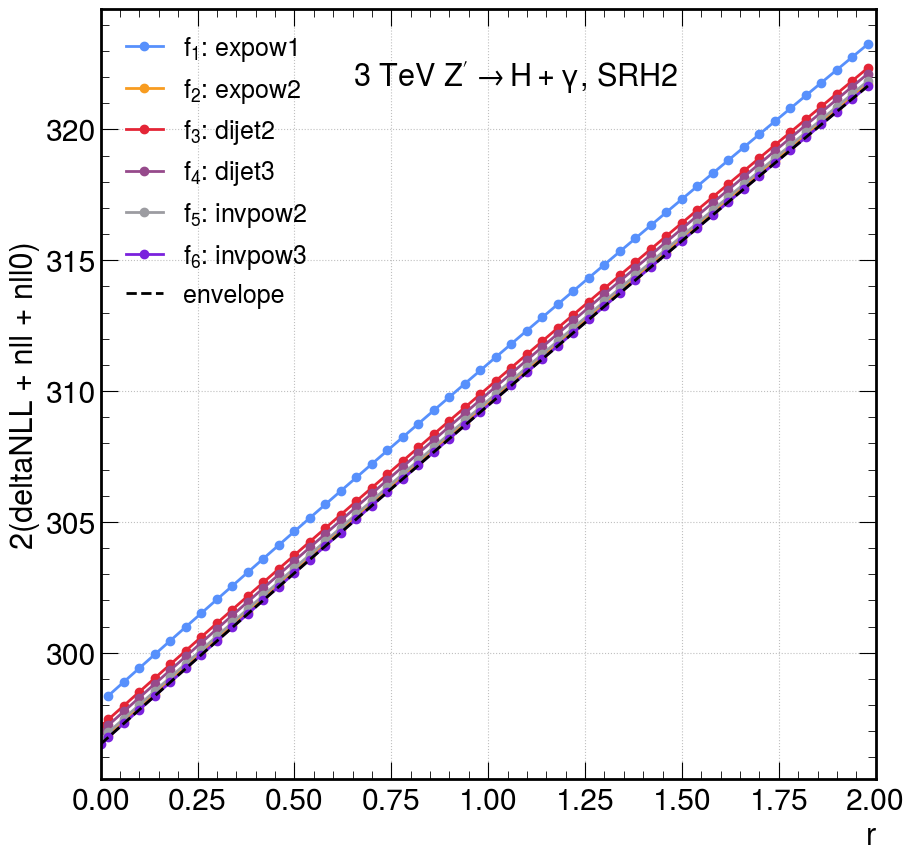

In [3]:
result = {}
os.system("combine -M MultiDimFit -d datacard/Run2/3000/SRH2.txt --algo grid --setParameterRanges r=0,2 --cminDefaultMinimizerStrategy 0 --saveNLL -n .envelope -m 125 --setParameters pdfindex_SRH1=-1,pdfindex_SRH2=-1 --X-rtd REMOVE_CONSTANT_ZERO_POINT=1")
result['envelope'] = uproot.open('higgsCombine.envelope.MultiDimFit.mH125.root')
function = {
    0: r'$f_1$: expow1',
    1: r'$f_2$: expow2',
    2: r'$f_3$: dijet2',
    3: r'$f_4$: dijet3',
    4: r'$f_5$: invpow2',
    5: r'$f_6$: invpow3',
}
for i in range(6):
    os.system(f"combine -M MultiDimFit -d datacard/Run2/3000/SRH2.txt --algo grid --setParameterRanges r=0,2 --cminDefaultMinimizerStrategy 0 --saveNLL -n .fixed_pdf_{i} -m 125 --setParameters pdfindex_SRH1=-1,pdfindex_SRH2={i} --freezeParameters pdfindex_SRH1,pdfindex_SRH2 --X-rtd REMOVE_CONSTANT_ZERO_POINT=1")
    result[function[i]] = uproot.open(f'higgsCombine.fixed_pdf_{i}.MultiDimFit.mH125.root')

x, y = {}, {}
for k in result:
    x[k]=result[k]['limit']['r'].array()
    y[k]=2*(result[k]['limit']['deltaNLL'].array()+result[k]['limit']['nll'].array()+result[k]['limit']['nll0'].array())

hep.style.use("CMS")
plt.figure(figsize=(10, 10))

for k in result:
    if k == 'envelope':
        continue
    plt.plot(x[k], y[k], '.-', label=k, linewidth=2,markersize=12)
plt.plot(x['envelope'], y['envelope'], '--', label='envelope', color='black', linewidth=2)

plt.xlim(0, 2)
plt.xlabel('r', fontsize=22, ha='right', x=1)
plt.ylabel('2(deltaNLL + nll + nll0)', fontsize=22, ha='center')
plt.text(x=0.65, y=0.9*plt.ylim()[1]+0.1*plt.ylim()[0], s=r'3 TeV $Z^\prime\to H+\gamma$, SRH2', fontsize=22)
plt.grid(True)
plt.legend(loc="best", ncol=1, frameon=False, fontsize=18)

os.makedirs('../plots/fit/Run2/', exist_ok=True)
plt.savefig('../plots/fit/Run2/likelihood_SRH2_3000.pdf', bbox_inches='tight')
plt.show()
